## Importing necessary libraries that are pre installed

In [47]:
import SimpleITK as sitk
import numpy as np
from typing import Tuple
from pathlib import Path
import pydicom as dicom
import os
import pandas as pd
import nibabel as nib
import matplotlib
import matplotlib.pyplot as plt
from bg_atlasapi.bg_atlas import BrainGlobeAtlas
from bg_atlasapi import show_atlases
import ants
import SimpleITK as sitk
import numpy
import numpy as np
from typing import Tuple, Dict, Any, Dict, List
from skimage.transform import resize
from scipy.ndimage import binary_fill_holes, label, binary_closing, generate_binary_structure
from scipy.ndimage import binary_opening
from scipy.ndimage import sum as ndi_sum
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting
from matplotlib.backends.backend_pdf import PdfPages

os.chdir('/home/jovyan/work/code/')


In [10]:
#atlas_p28 = BrainGlobeAtlas("admba_3d_p28_mouse_16.752um")

In [11]:
#atlas_p28 = BrainGlobeAtlas("admba_3d_p28_mouse_16.752um")

In [12]:
#atlas_p56.lookup_df.to_csv('lookuptable_p56_mouse.xlsx')

In [429]:
show_atlases() # pick an atlas

╭───────────────────────────────── Brainglobe Atlases ─────────────────────────────────╮
│                                                                           Latest     │
│  Name                              Downloaded  Updated  Local version    version     │
│  admba_3d_e18_5_mouse_16um             ✔          ✔          1.0           1.0       │
│  example_mouse_100um                                                       1.2       │
│  allen_mouse_10um                                                          1.2       │
│  allen_mouse_25um                                                          1.2       │
│  allen_mouse_50um                                                          1.2       │
│  allen_mouse_100um                                                         1.2       │
│  mpin_zfish_1um                                                            1.0       │
│  allen_human_500um                                                         0.1       │
│  kim_mouse_10um                                                            1.0       │
│  kim_mouse_25um                                                            1.0       │
│  kim_mouse_50um                                                            1.0       │
│  kim_mouse_100um                                                           1.0       │
│  osten_mouse_10um                                                          1.1       │
│  osten_mouse_25um                                                          1.1       │
│  osten_mouse_50um                                                          1.1       │
│  osten_mouse_100um                                                         1.1       │
│  allen_cord_20um                                                           1.0       │
│  azba_zfish_4um                                                            1.1       │
│  whs_sd_rat_39um                                                           1.0       │
│  perens_lsfm_mouse_20um                                                    1.0       │
│  admba_3d_e11_5_mouse_16um                                                 1.0       │
│  admba_3d_e13_5_mouse_16um                                                 1.0       │
│  admba_3d_e15_5_mouse_16um                                                 1.0       │
│  admba_3d_p4_mouse_16.752um                                                1.0       │
│  admba_3d_p14_mouse_16.752um                                               1.0       │
│  admba_3d_p28_mouse_16.752um                                               1.0       │
│  admba_3d_p56_mouse_25um                                                   1.0       │
│  princeton_mouse_20um                                                      1.0       │
│  kim_dev_mouse_stp_10um                                                    1.1       │
│  kim_dev_mouse_idisco_10um                                                 1.1       │
│  kim_dev_mouse_mri_a0_10um                                                 1.1       │
│  kim_dev_mouse_mri_adc_10um                                                1.1       │
│  kim_dev_mouse_mri_dwi_10um                                                1.1       │
│  kim_dev_mouse_mri_fa_10um                                                 1.1       │
│  kim_dev_mouse_mri_mtr_10um                                                1.1       │
│  kim_dev_mouse_mri_t2_10um                                                 1.1       │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [16]:
# defining atlas + look up
atlas = BrainGlobeAtlas("admba_3d_e18_5_mouse_16um")

reference_image = atlas.reference
registration_atlas = reference_image
annotation_image = atlas.annotation
look_up = atlas.lookup_df

## Helper functions for image processing

In [18]:
def image_reorientation(image: nib.Nifti1Image) -> : nib.Nifti1Image:
    
    data = image.get_fdata()
    current_orientation = nib.aff2axcodes(image.affine)
    
    # Define the standard orientation you want, e.g., RAS (Right-Anterior-Superior)
    standard_orientation = ('R', 'A', 'S')
    if any([ord_ == 'nan' for ord_ in current_orientation]):
        raise ValueError("Orientation information contains NaN values.")
    
    reoriented_data = np.swapaxes(data, 0, 2)
    reoriented_affine = np.copy(image.affine)
    reoriented_affine[:, [0, 2]] = reoriented_affine[:, [2, 0]]
    reoriented_affine[:, 0] *= -1
    
    reoriented_img = nib.Nifti1Image(reoriented_data, reoriented_affine)

    return reoriented_img

In [22]:
def register_images_antspy(atlas: np.ndarray, mri_scan: nib.Nifti1Image) -> Tuple[ants.core.ants_image.ANTsImage, ants.core.ants_transform.ANTsTransform]:
    atlas_ants = ants.from_numpy(atlas.astype(np.float32))
    mri_scan_ants = ants.from_numpy(mri_scan)
    atlas_ants = ants.resample_image(atlas_ants, mri_scan_ants.shape, use_voxels=True, interp_type=1)

    # Perform the registration
    # Here we use SyN (symmetric normalization), a powerful non-linear registration algorithm
    # We also use a multi-resolution strategy with two levels
    mytx = ants.registration(fixed=mri_scan_ants, moving=atlas_ants, type_of_transform='SyN', grad_step=0.7, random_seed=5)

    # Apply the transformation to the atlas
    resampled_atlas = ants.apply_transforms(fixed=mri_scan_ants, moving=atlas_ants, transformlist=mytx['fwdtransforms'], interpolator='nearestNeighbor')

    return resampled_atlas, mytx


In [23]:
def apply_transform_to_mask(mask: np.ndarray, transform: ants.core.ants_transform.ANTsTransform, mri_scan: nib.Nifti1Image) -> ants.core.ants_image.ANTsImage:
    # Convert the numpy array to an ANTsImage
    mask_ants = ants.from_numpy(mask.astype(np.float32))

    # Apply the transformation to the mask
    resampled_mask = ants.apply_transforms(fixed=ants.from_numpy(mri_scan.get_fdata().astype(np.float32)), moving=mask_ants, transformlist=transform['fwdtransforms'], interpolator='nearestNeighbor')

    return resampled_mask


In [32]:
def smooth_mask(resampled_mask: ants.core.ants_image.ANTsImage) -> np.ndarray:
    resampled_mask_np = resampled_mask.numpy()

    resampled_mask_np = binary_fill_holes(resampled_mask_np).astype(np.float32)
    
    structure = generate_binary_structure(3, 2)  # 3 for 3D image, 2 means fully connected
    labeled_array, num_features = label(resampled_mask_np, structure=structure)
    sizes = ndi_sum(resampled_mask_np, labeled_array, range(num_features + 1))
    
    min_size = 100  # This is just an example, you would set this based on your application
    mask_size = sizes[labeled_array] > min_size
    resampled_mask_np = mask_size.astype(np.float32)

    return resampled_mask_np

## Some functions for data analysis

In [37]:
def create_dataframe(mask: np.ndarray, mask_name: str, num_bins=8) -> pd.DataFrame:
    # adapt number of bins 
    data = mask.flatten()

    # Exclude zero-values
    data = data[data != 0]

    # Compute statistics
    mean = np.mean(data)
    median = np.median(data)
    std_dev = np.std(data)
    variance = np.var(data)
    min_val = np.min(data)
    max_val = np.max(data)
    percentile_25 = np.percentile(data, 25)  # 25th percentile
    percentile_75 = np.percentile(data, 75)  # 75th percentile
    hist, bin_edges = np.histogram(data, bins=num_bins)

    # Create a dictionary of the statistics
    statistics = {
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev,
        'Variance': variance,
        'Min': min_val,
        'Max': max_val,
        '25th Percentile': percentile_25,
        '75th Percentile': percentile_75,
    }

    # Create a dataframe from the statistics dictionary
    df = pd.DataFrame.from_dict(statistics, orient='index', columns=['Value'])
    df['anatomical region'] = mask_name
    # Set the index to the mask name
    df.index.name = mask_name

    # Add histogram as a separate column
    df['Histogram'] = hist

    return df

In [41]:
def save_fig(data: np.ndarray, name: str) -> Tuple[matplotlib.figure.Figure, plt.Axes]:
    # Exclude zero-values
    data = data[data != 0]
    
    # Plot histogram
    plt.hist(data, bins=100)
    plt.title(f'Histogram of FA values for {name} region')
    plt.xlabel('FA values')
    plt.ylabel('Frequency')
    plt.savefig(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/FA Map/{name}_histogram.png")
    plt.show()

In [ ]:
atlas_np = registration_atlas # Random numpy array for demonstration
resampled_atlas, transform = register_images_antspy(atlas_np, reoriented_fa_map.get_fdata())

## Applying rotation to initial fa map

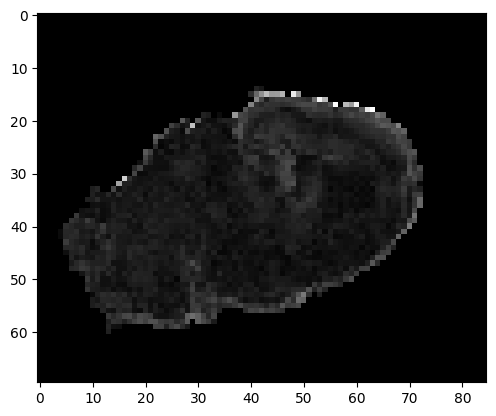

In [14]:
plt.imshow(fa_map.get_fdata()[70, :, :], cmap='gray')
plt.show()

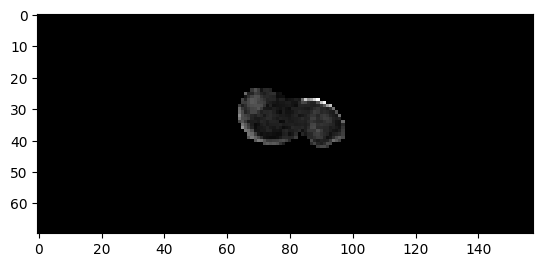

In [27]:
# looking at same slice of reoriented image
plt.imshow(reoriented_fa_map.get_fdata()[70, :, :], cmap='gray')
plt.show()

## saving rotated map

In [ ]:
# saving 
fa_map = nib.load('../P0/nifti_images/DTI_inverty_fa.nii')
reoriented_fa_map = image_reorientation(fa_map)
nib.Nifti1Image.to_filename(reoriented_fa_map, 'reoriented_fa_map_p0_mouse.nii.gz')

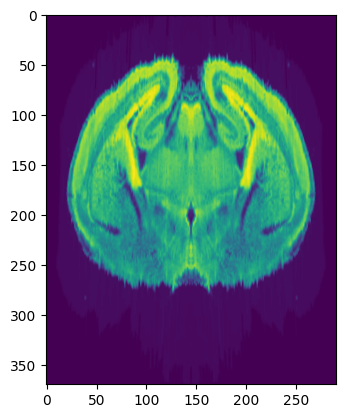

In [28]:
# quick look at atlas
plt.imshow(registration_atlas[200, :, :])
plt.show()

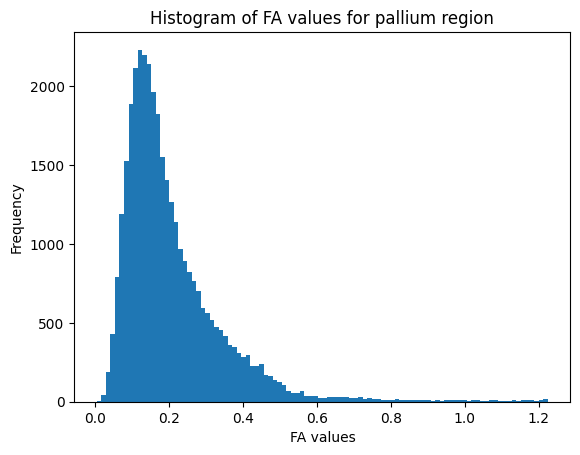

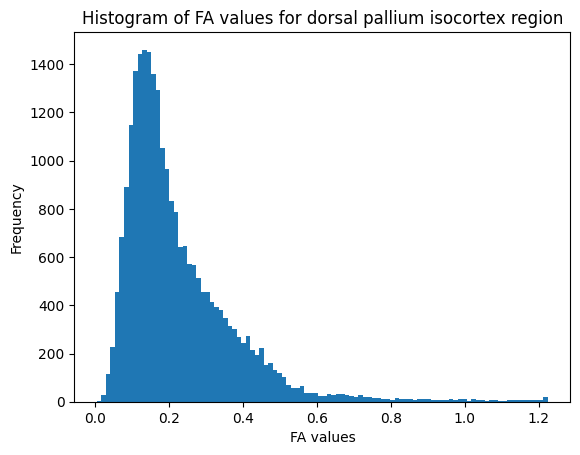

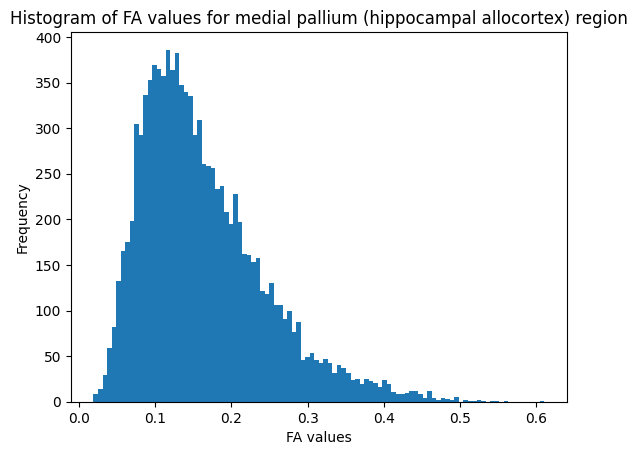

In [369]:
# writing fa values to dataframe 
combined_df = pd.DataFrame()

for structure in ['Pall', 'DPall', 'MPall']:
    name = look_up.loc[look_up.acronym == structure].name.values[0]
    name = name.replace('/', ' ')
    # creating dir
    if not os.path.exists(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}"):
        os.mkdir(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}")
        os.mkdir(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/FA Map")
        os.mkdir(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/Atlas")
        
        
    mask = atlas.get_structure_mask(structure)
    resampled_mask = apply_transform_to_mask(mask, transform, reoriented_fa_map)
    smoothed_mask = smooth_mask(resampled_mask)
    if smoothed_mask.max() == 0:
        print(name)
        
    roi = reoriented_fa_map.get_fdata() * smoothed_mask
    df = create_dataframe(roi, name)
    combined_df = pd.concat([combined_df, df])
    atlas_roi = registration_atlas * mask
    save_fig(roi, name)
    
    nib.save(nib.Nifti1Image(roi, reoriented_fa_map.affine), f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/FA Map/{name}_roi_of_fa_map.nii.gz")
    nib.save(nib.Nifti1Image(smoothed_mask, reoriented_fa_map.affine), f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/FA Map/{name}_roi_binary_mask.nii.gz")
    np.save(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/FA Map/{name}_roi_of_fa_map.npy", roi, allow_pickle=True)
    np.save(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/FA Map/{name}_roi_binary_mask.npy", smoothed_mask, allow_pickle=True)
    np.save(f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/Atlas/{name}_original_atlas_roi.npy", atlas_roi, allow_pickle=True)
    nib.save(nib.Nifti1Image(atlas_roi, np.eye(4)), f"../P0/P0_mouse_anatomical_region/cortex_structure/{name}/Atlas/{name}_original_atlas_roi.nii.gz")

    

    
    

In [332]:
combined_df.to_excel('../P0/P0_mouse_anatomical_region/cortex_structure/pallium/fa_values_pivot.xlsx')

In [385]:
combined_df.groupby(by=["anatomical region"], dropna=False).first()

,Value,Histogram
anatomical region,,
dorsal pallium isocortex,0.226091,9983
medial pallium (hippocampal allocortex),0.163297,1980
pallium,0.207499,15757


In [401]:
combined_df.reset_index().set_index(['anatomical region', 'index']).to_excel('../P0/P0_mouse_anatomical_region/cortex_structure/pallium/fa_values_pivot.xlsx')

In [400]:
combined_df.reset_index().set_index(['anatomical region', 'index'])

Value  \
anatomical region                       index                          
pallium                                 Mean                0.207499   
                                        Median              0.168262   
                                        Standard Deviation  0.140525   
                                        Variance            0.019747   
                                        Min                 0.004383   
                                        Max                 1.224721   
                                        25th Percentile     0.117565   
                                        75th Percentile     0.256641   
dorsal pallium isocortex                Mean                0.226091   
                                        Median              0.180199   
                                        Standard Deviation  0.155339   
                                        Variance            0.024130   
                                        Min                 0.004383   
                                        Max                 1.224721   
                                        25th Percentile     0.124914   
                                        75th Percentile     0.285155   
medial pallium (hippocampal allocortex) Mean                0.163297   
                                        Median              0.146169   
                                        Standard Deviation  0.081282   
                                        Variance            0.006607   
                                        Min                 0.019252   
                                        Max                 0.610539   
                                        25th Percentile     0.103212   
                                        75th Percentile     0.207264   

                                                            Histogram  
anatomical region                       index                          
pallium                                 Mean                    15757  
                                        Median                  13467  
                                        Standard Deviation       4259  
                                        Variance                  988  
                                        Min                       309  
                                        Max                       140  
                                        25th Percentile           101  
                                        75th Percentile           104  
dorsal pallium isocortex                Mean                     9983  
                                        Median                   9443  
                                        Standard Deviation       3652  
                                        Variance                  957  
                                        Min                       309  
                                        Max                       140  
                                        25th Percentile           101  
                                        75th Percentile           104  
medial pallium (hippocampal allocortex) Mean                     1980  
                                        Median                   4275  
                                        Standard Deviation       2511  
                                        Variance                 1063  
                                        Min                       401  
                                        Max                       154  
                                        25th Percentile            27  
                                        75th Percentile             4

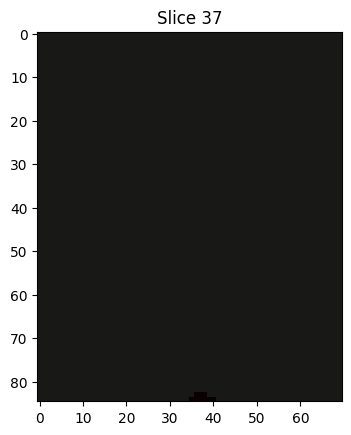

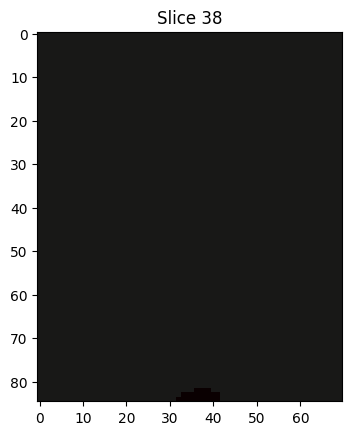

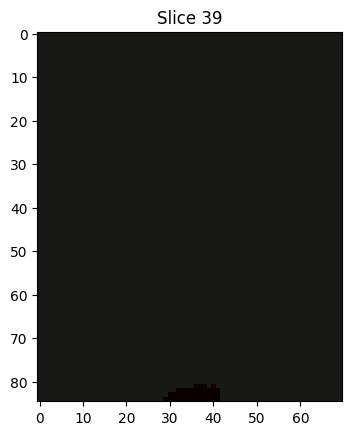

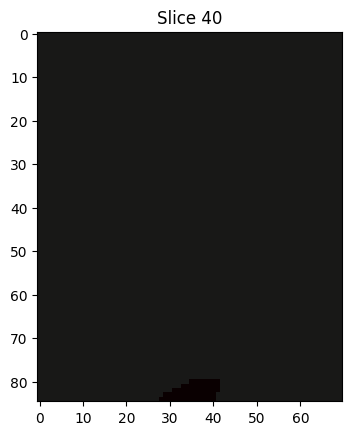

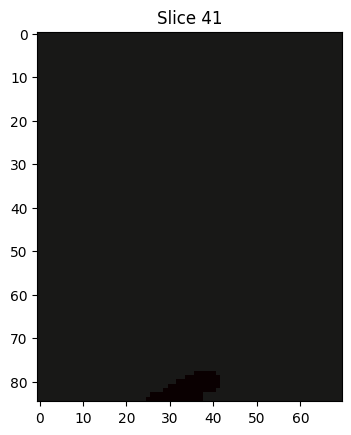

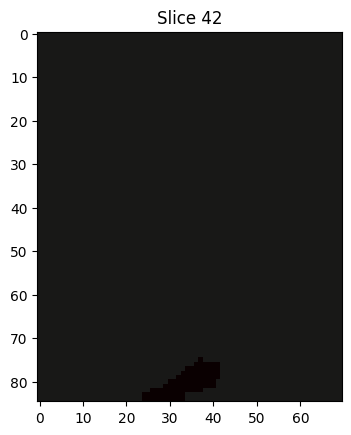

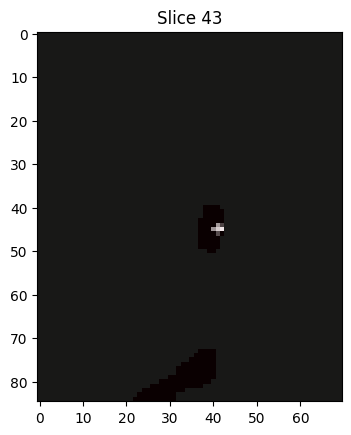

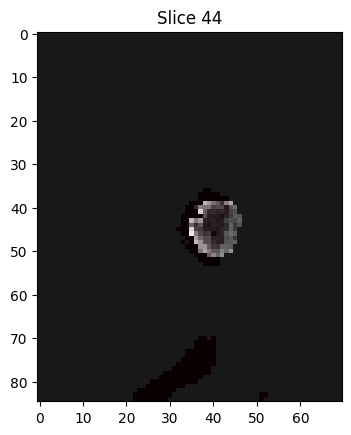

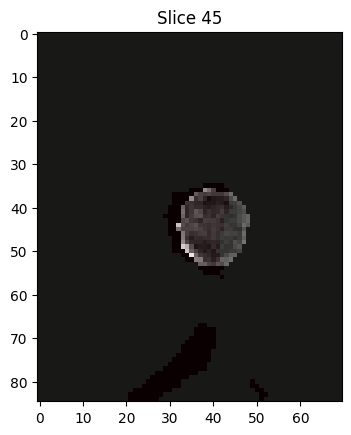

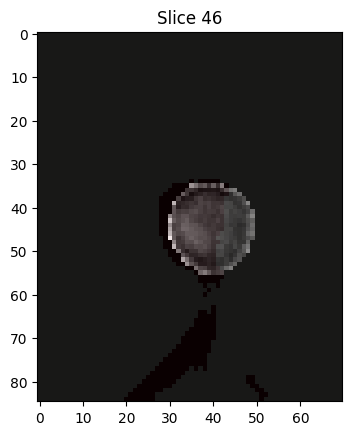

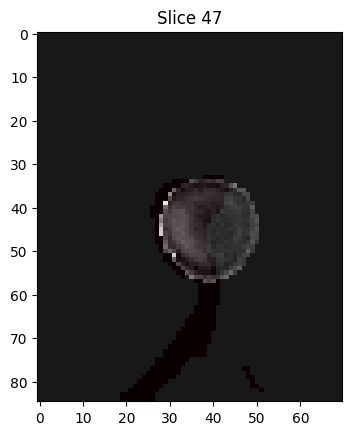

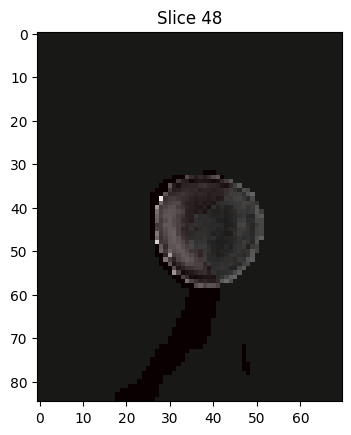

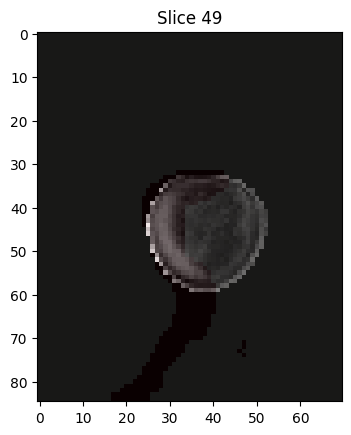

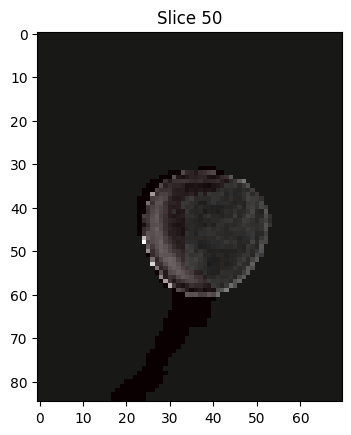

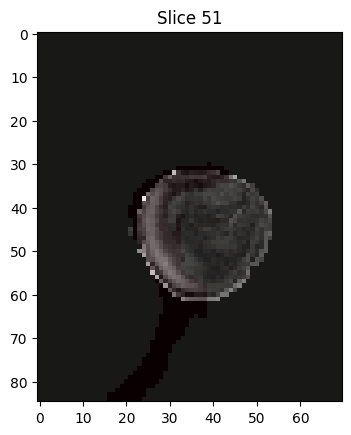

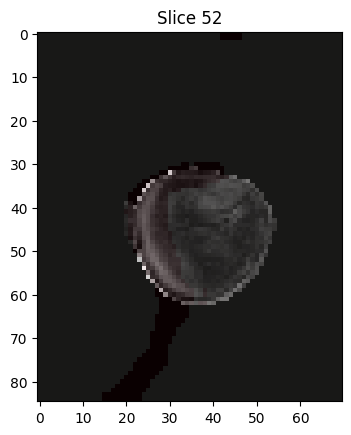

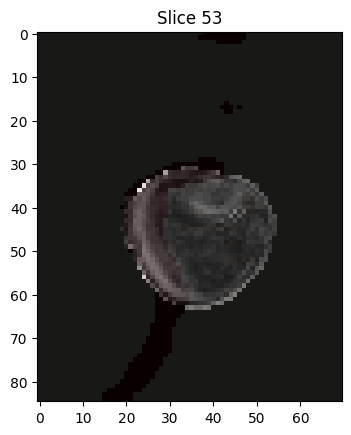

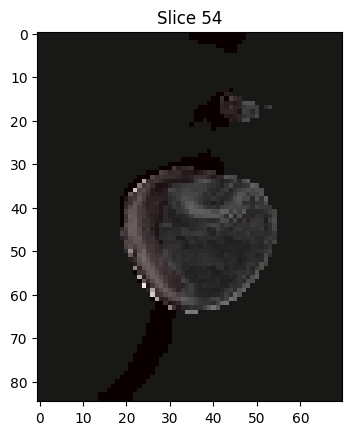

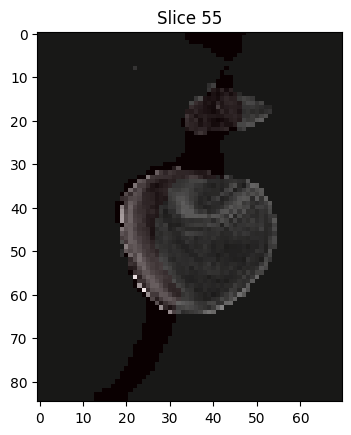

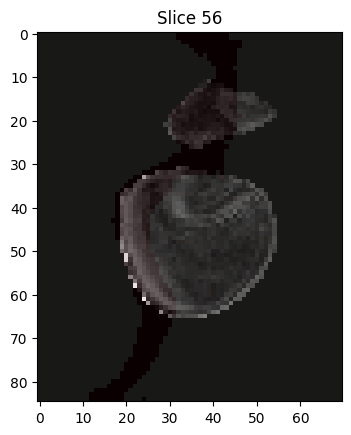

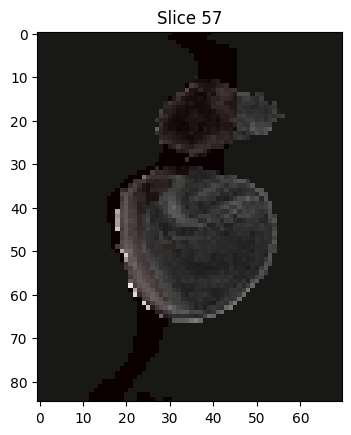

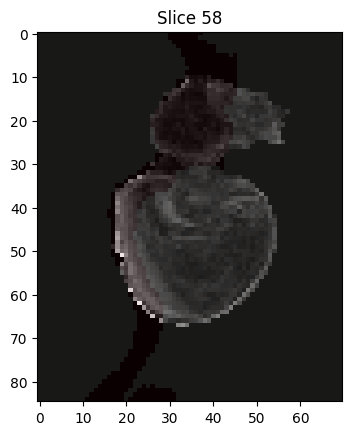

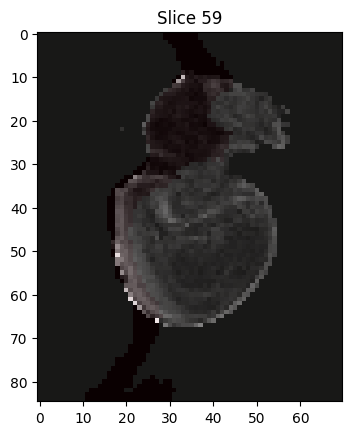

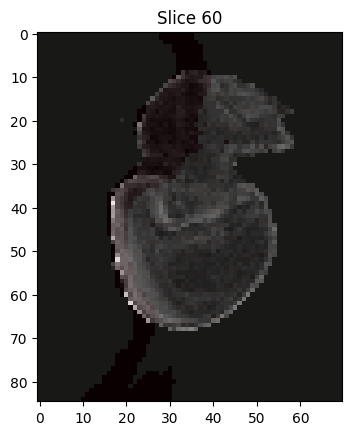

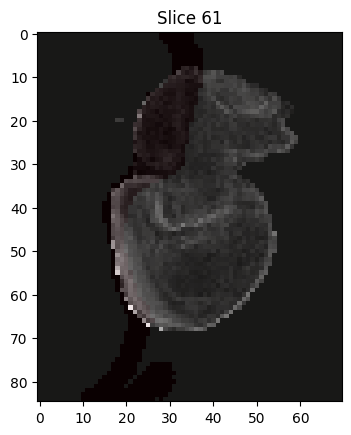

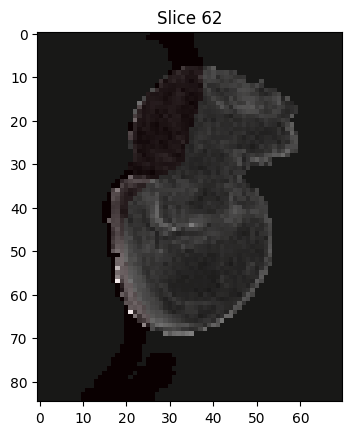

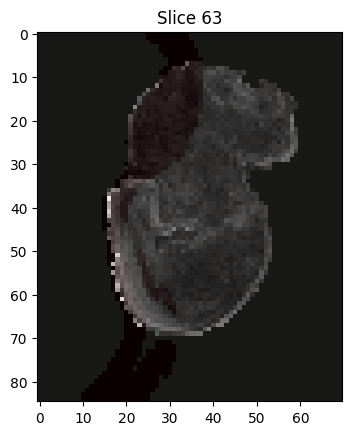

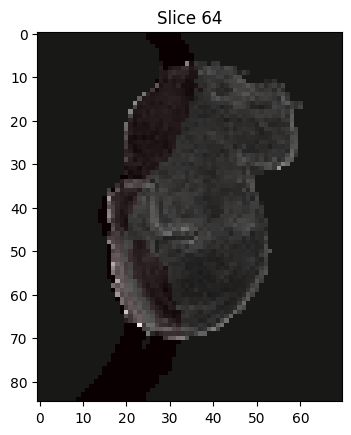

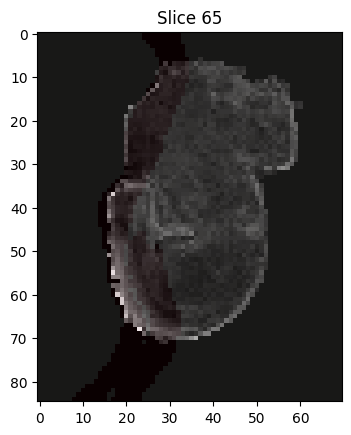

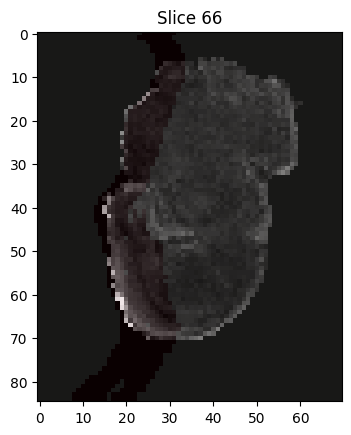

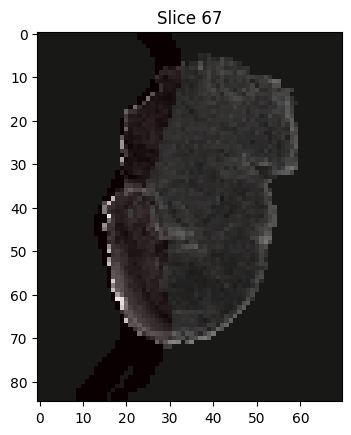

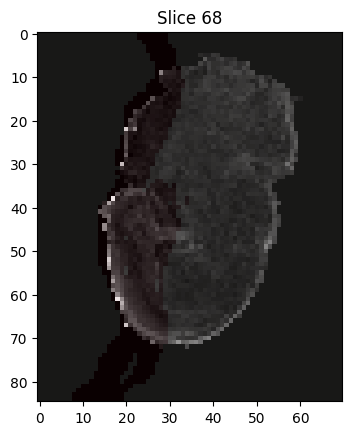

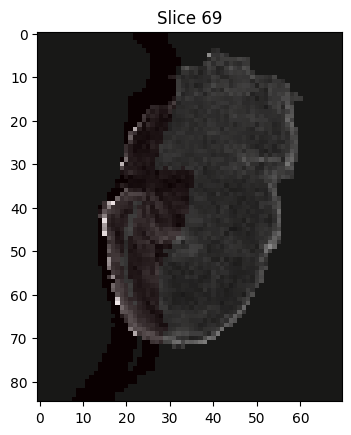

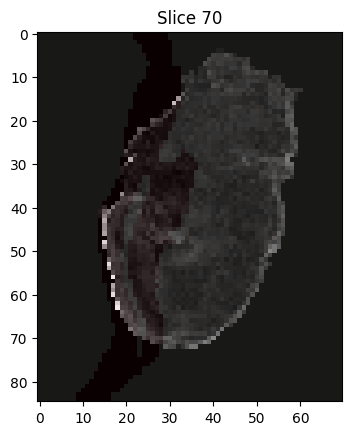

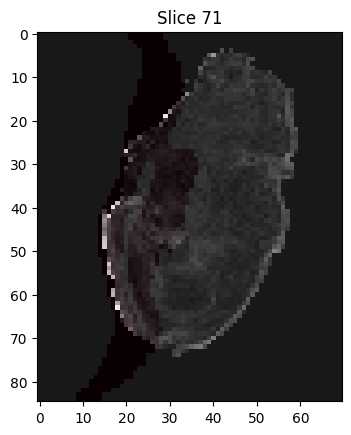

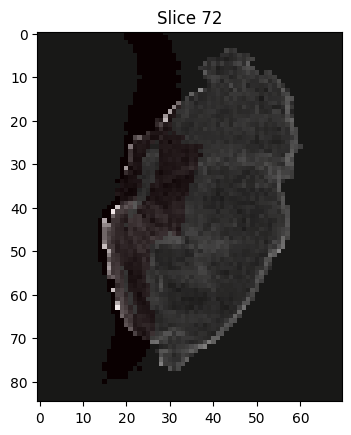

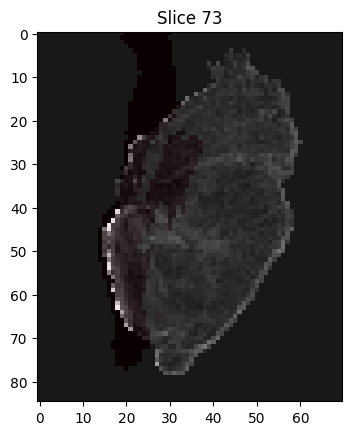

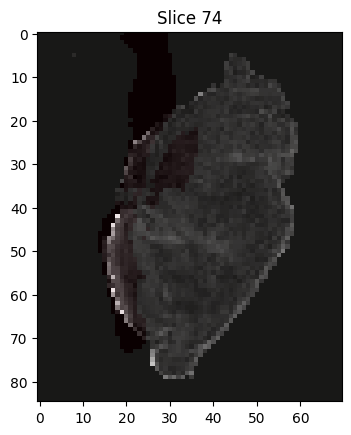

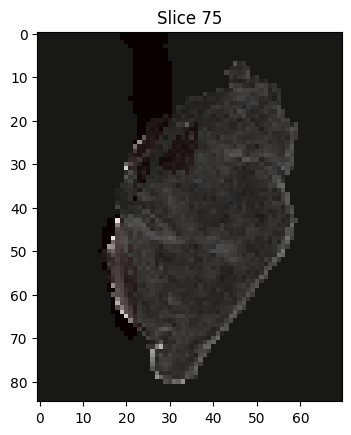

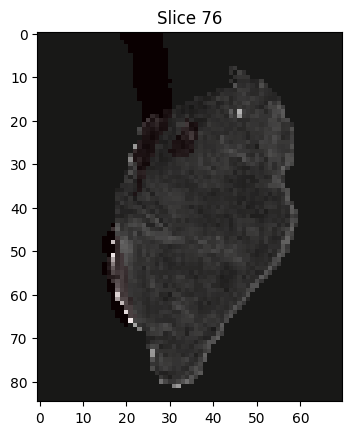

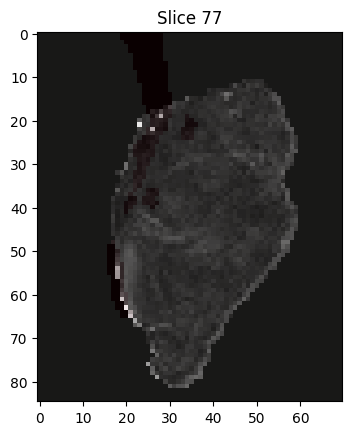

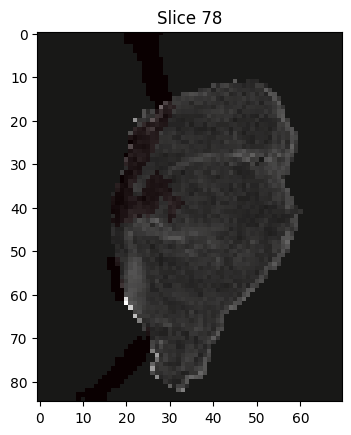

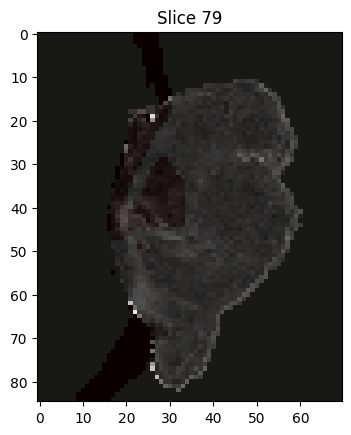

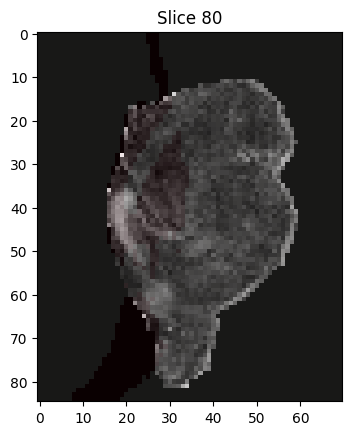

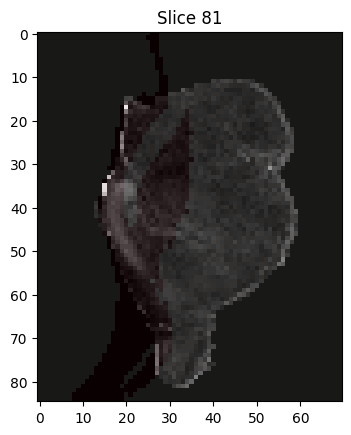

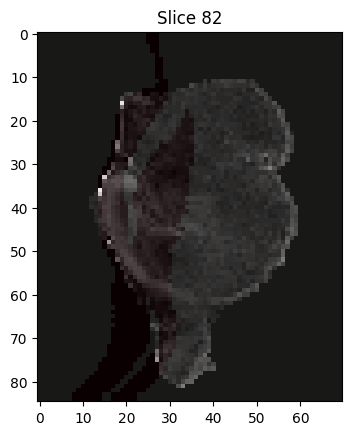

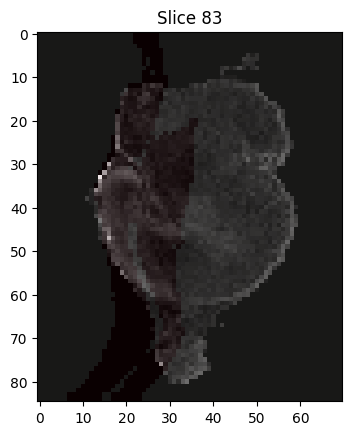

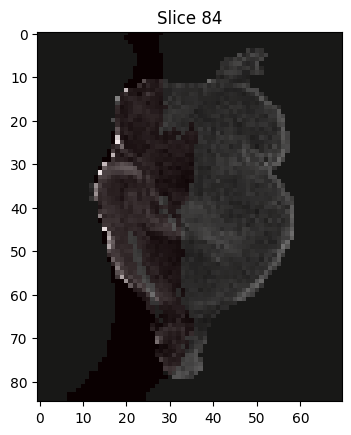

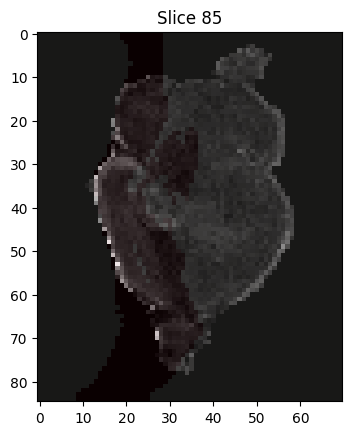

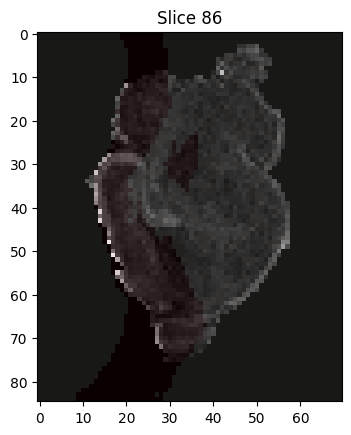

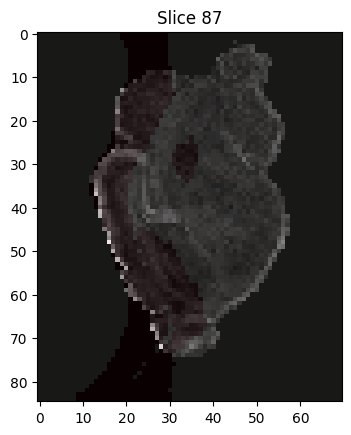

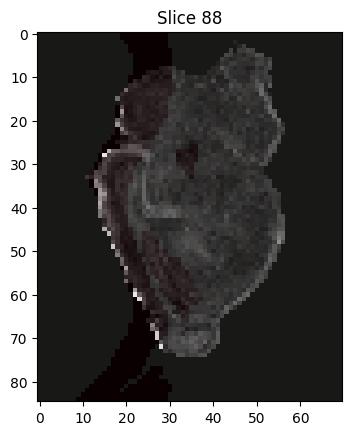

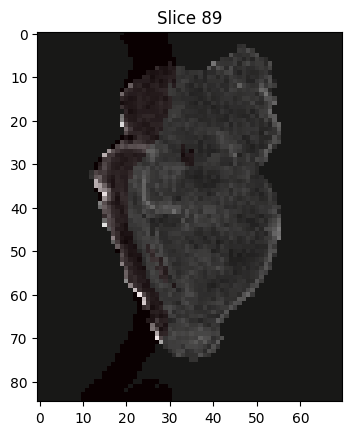

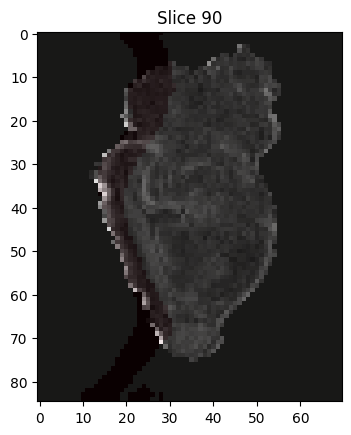

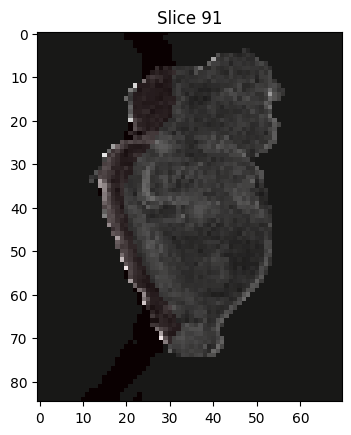

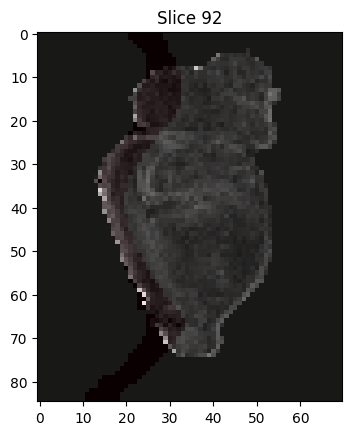

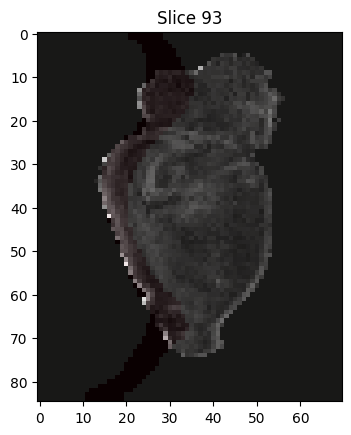

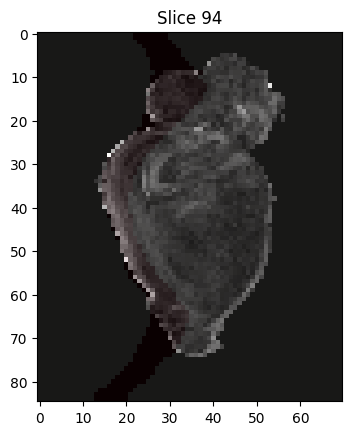

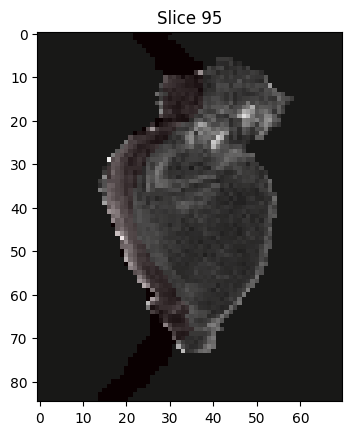

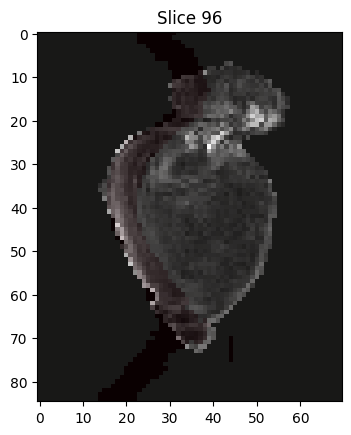

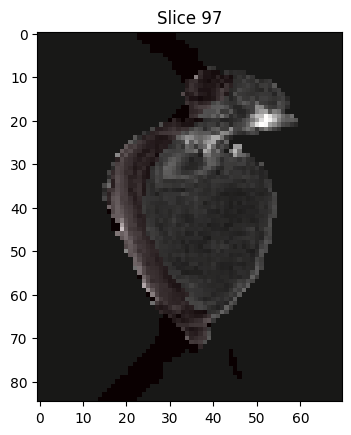

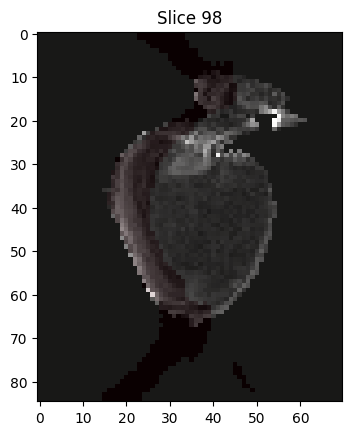

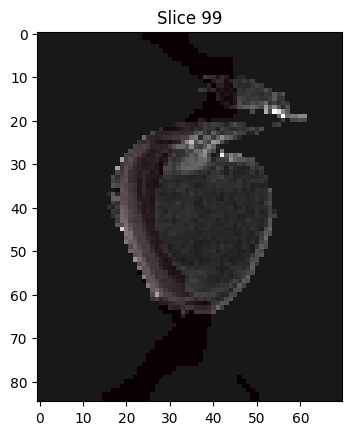

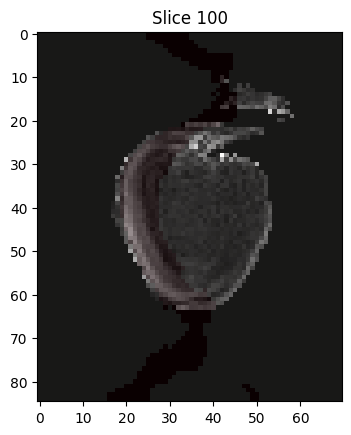

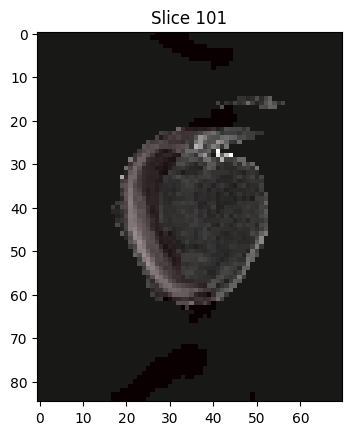

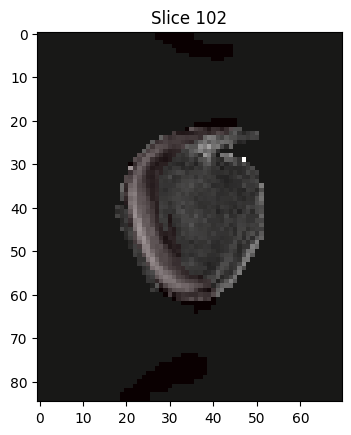

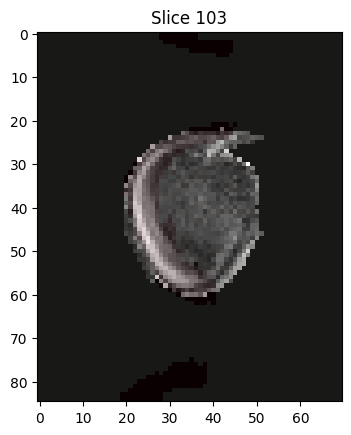

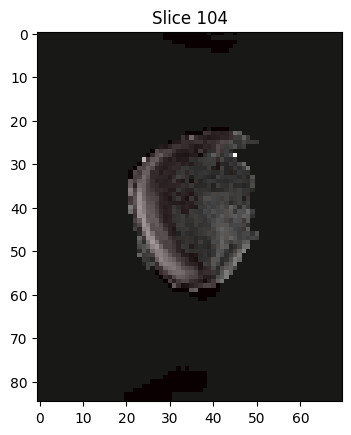

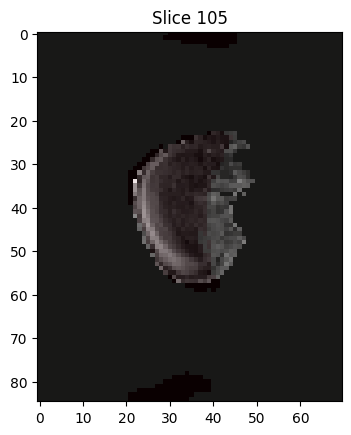

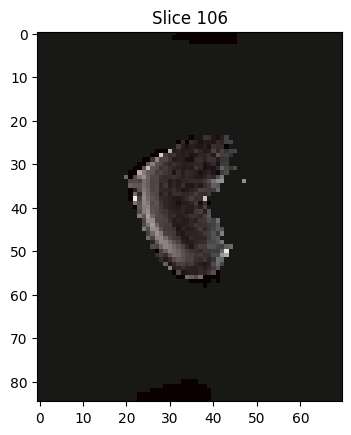

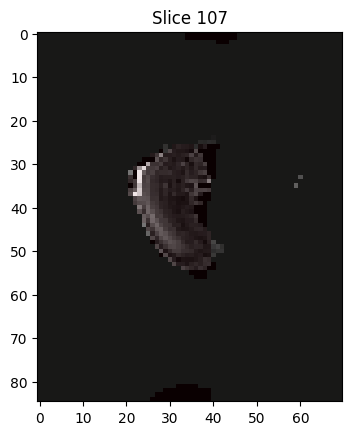

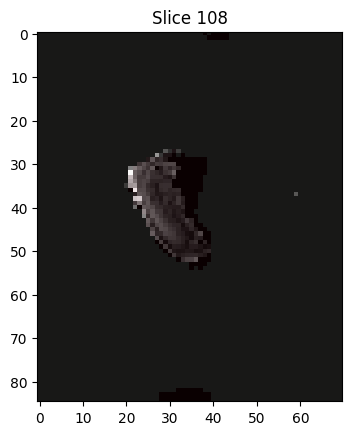

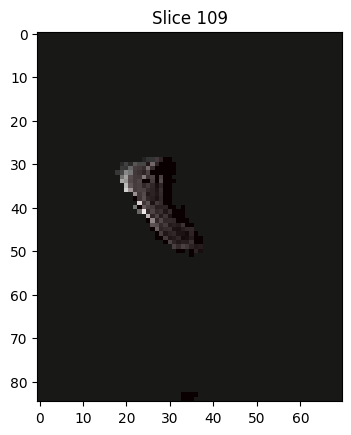

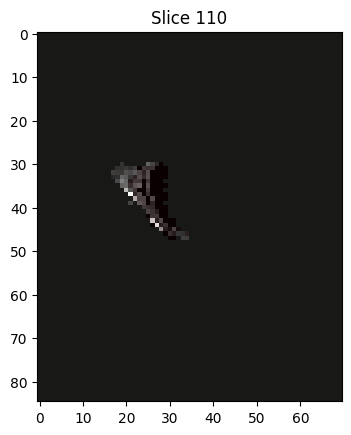

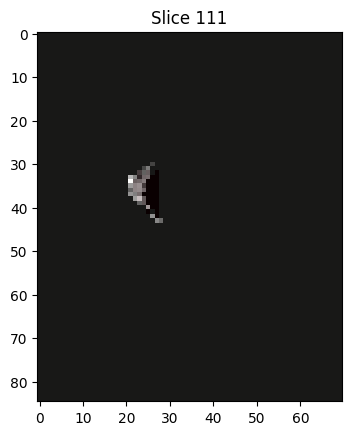

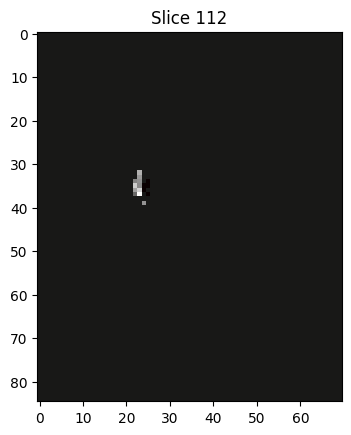

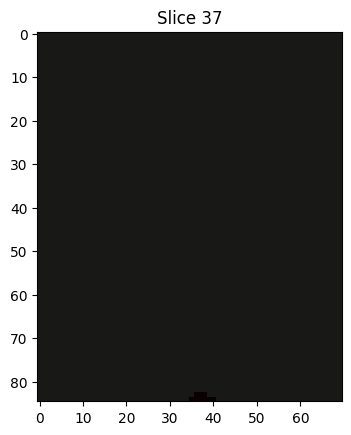

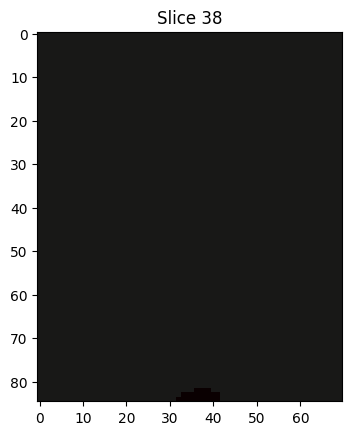

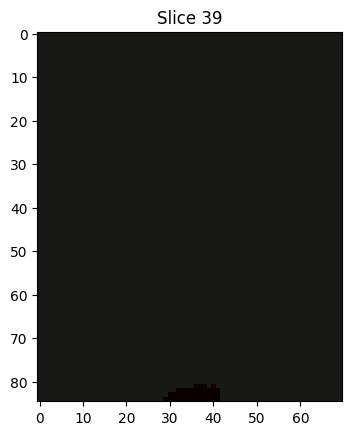

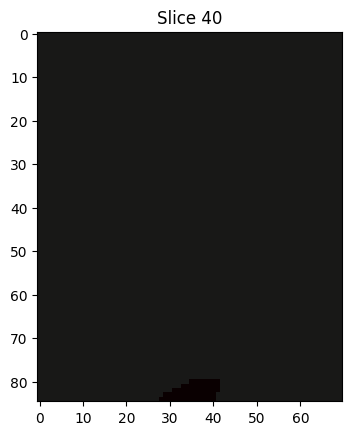

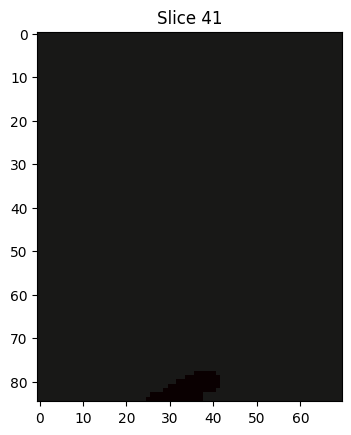

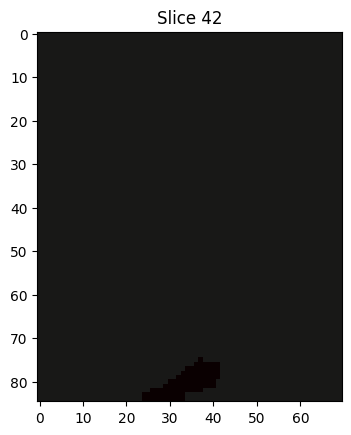

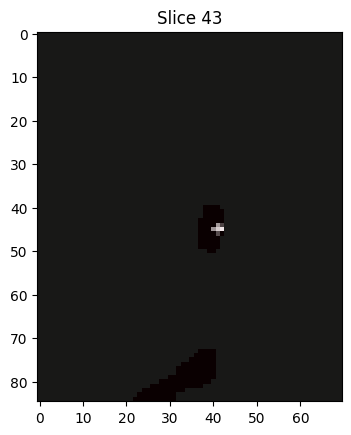

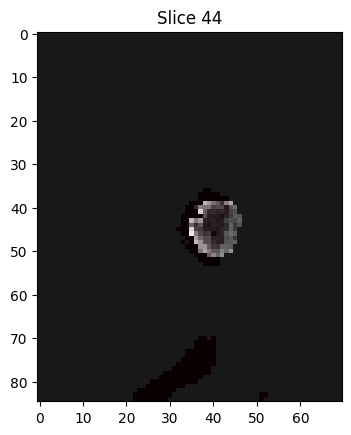

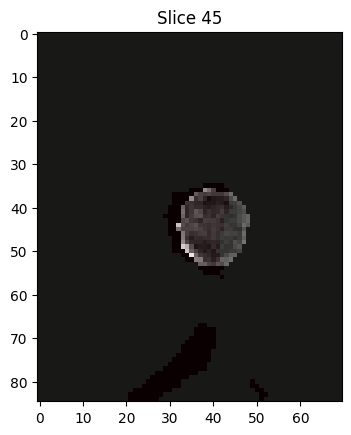

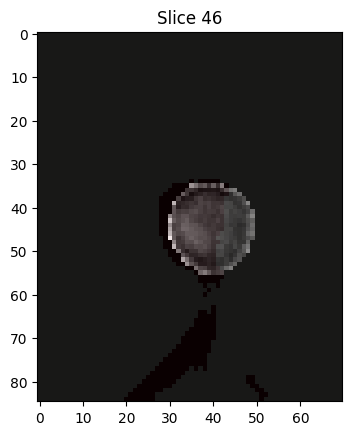

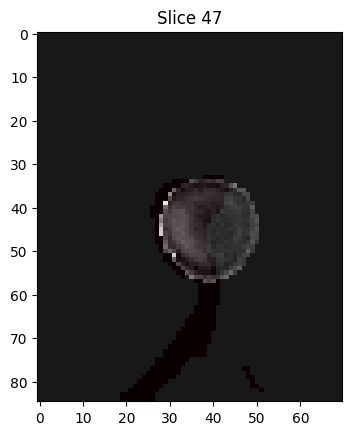

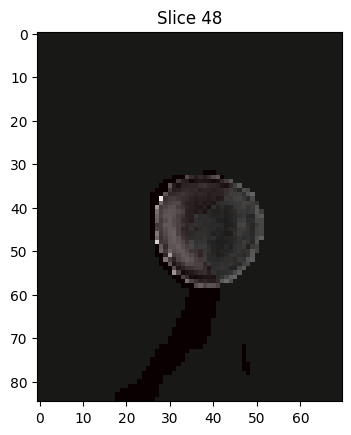

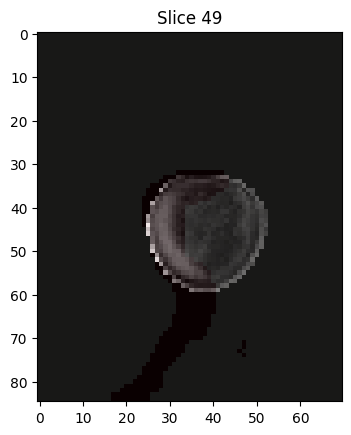

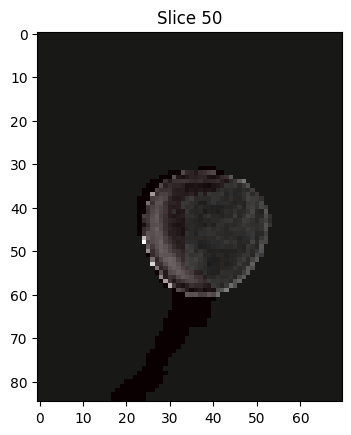

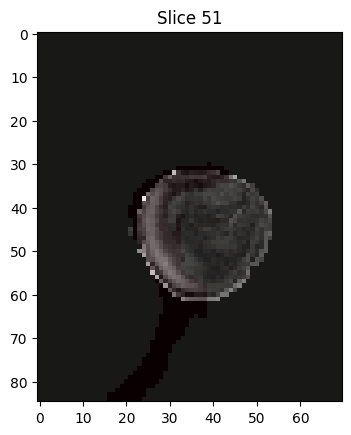

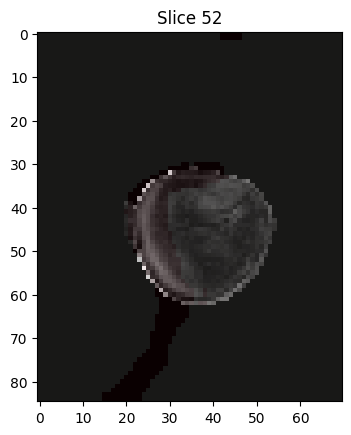

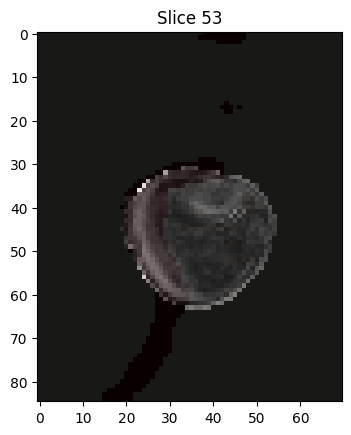

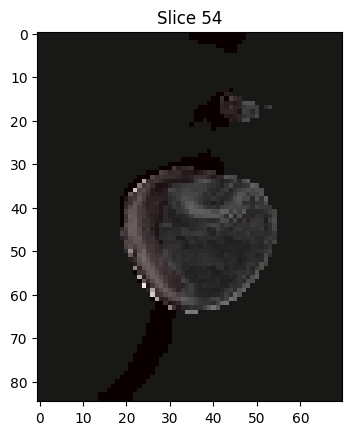

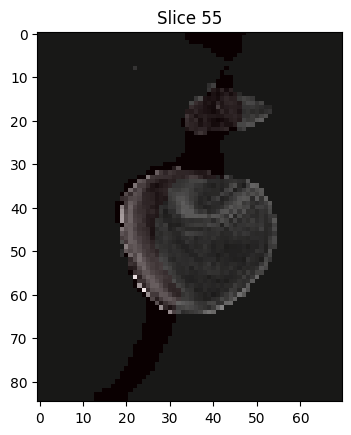

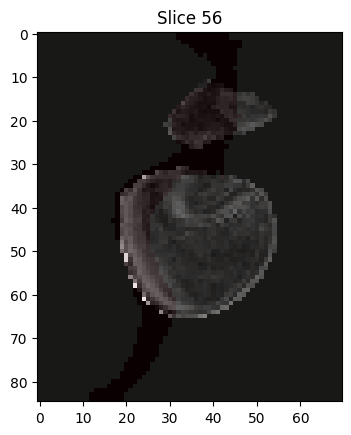

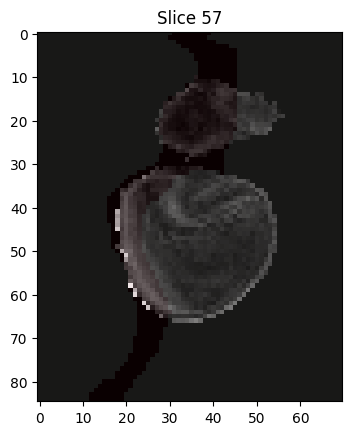

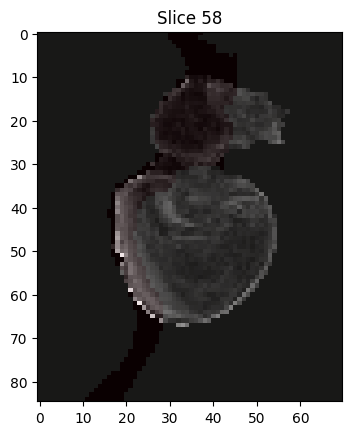

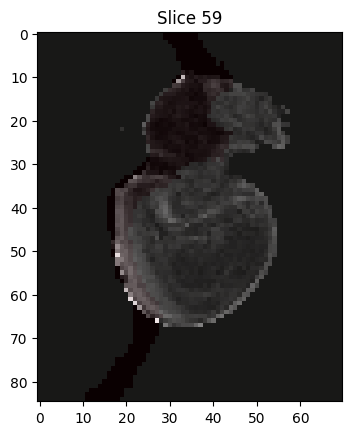

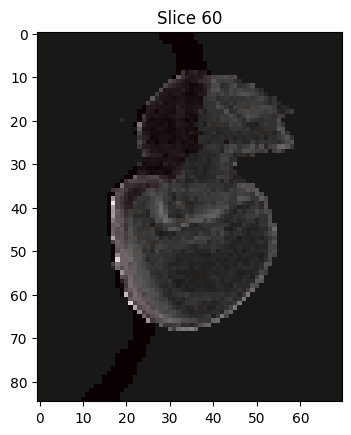

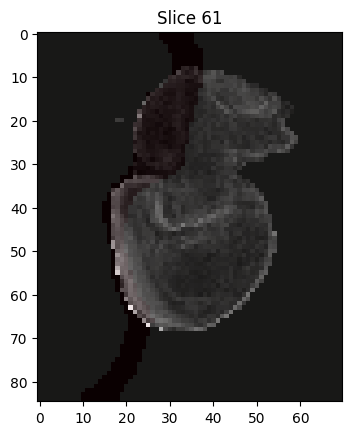

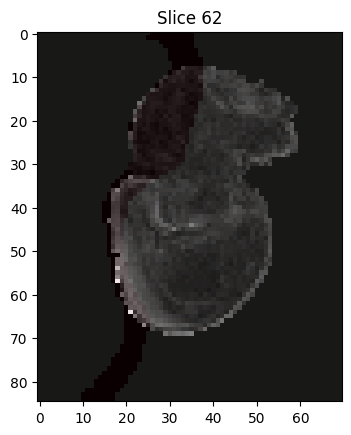

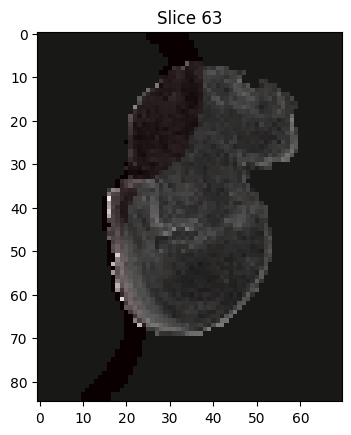

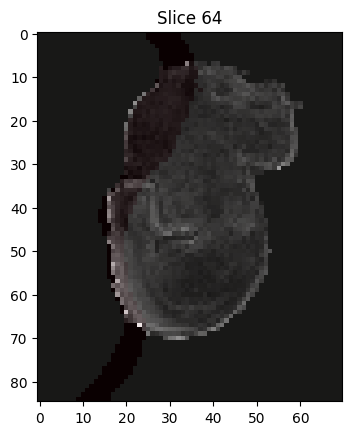

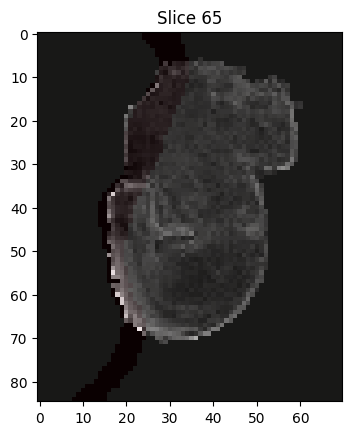

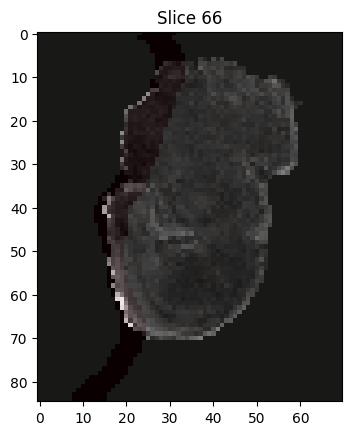

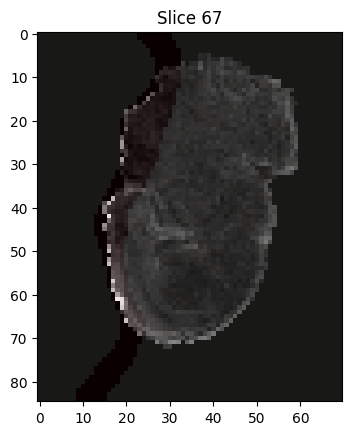

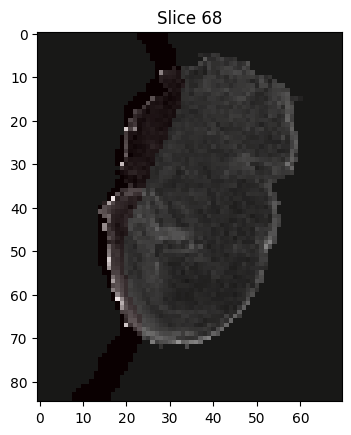

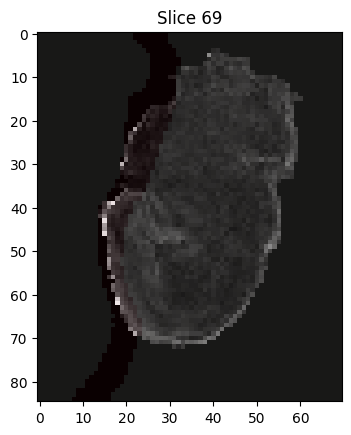

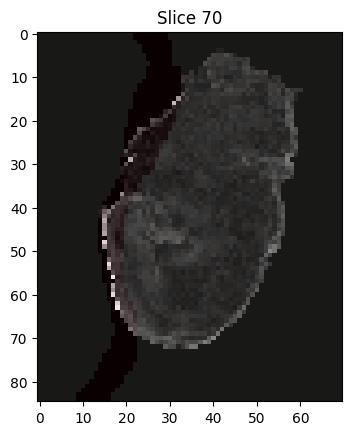

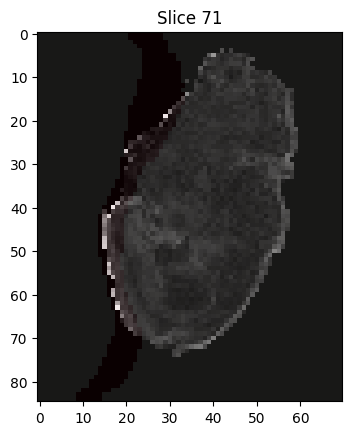

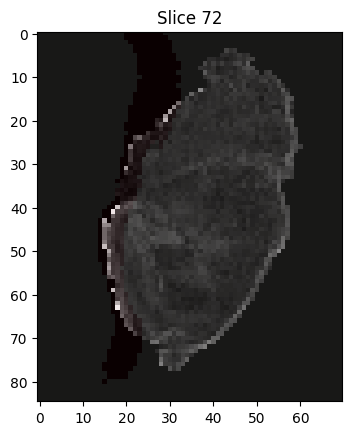

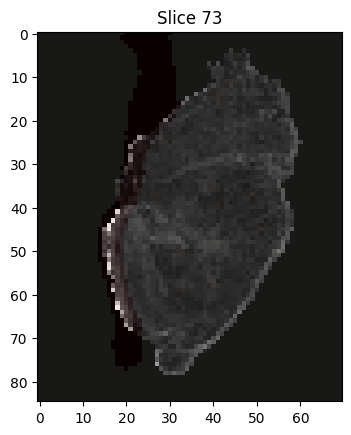

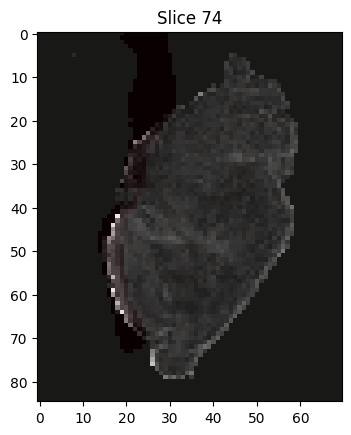

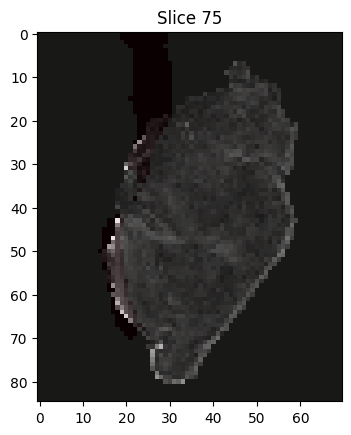

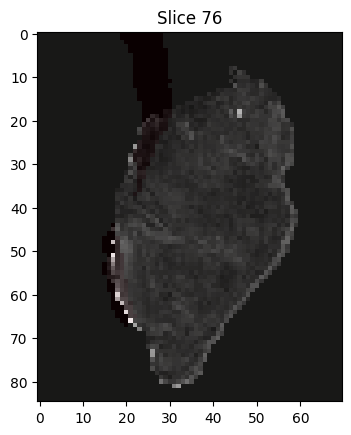

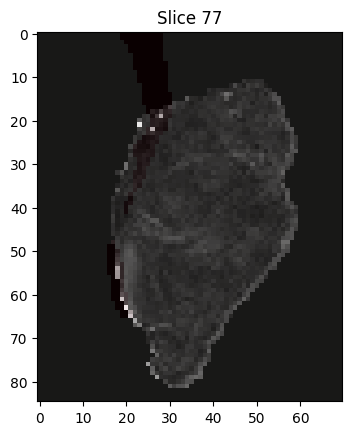

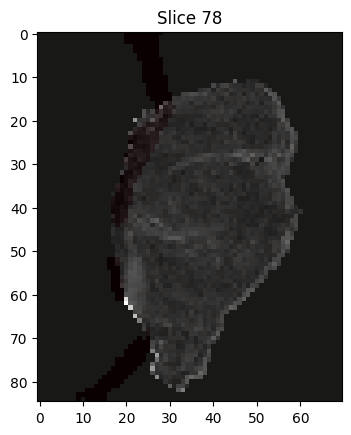

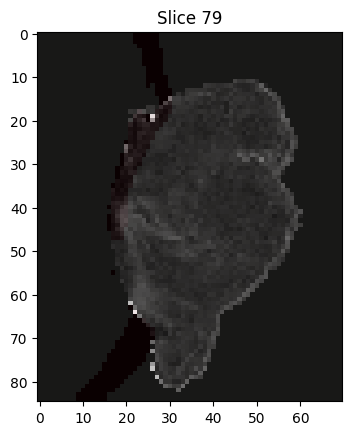

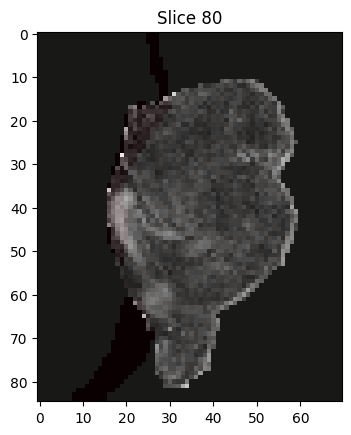

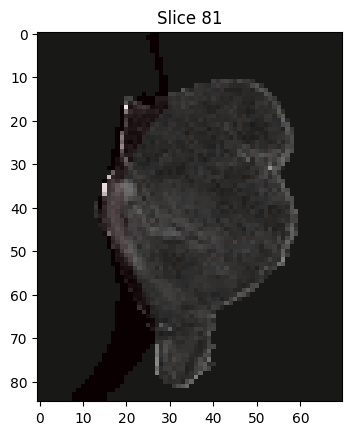

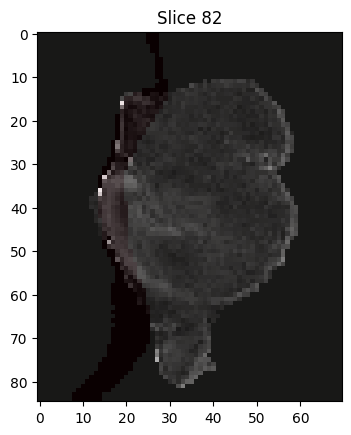

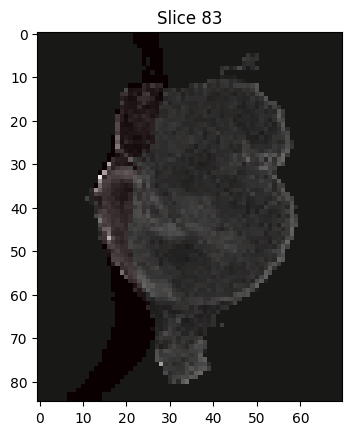

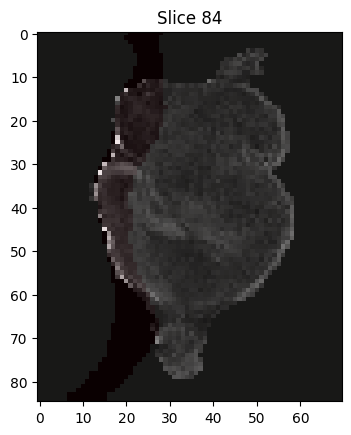

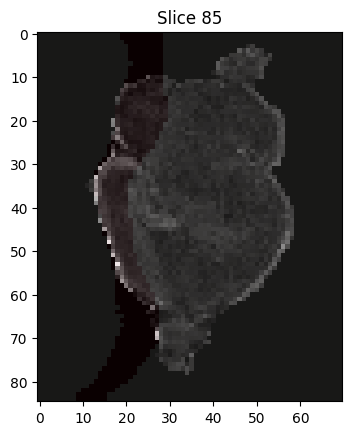

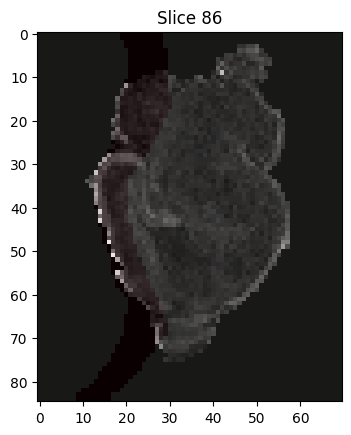

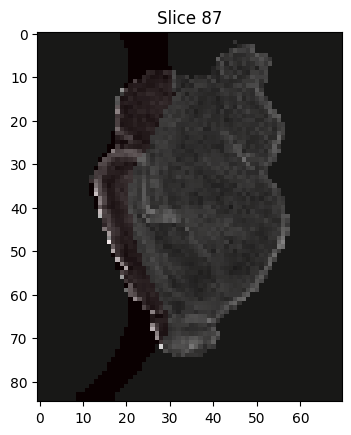

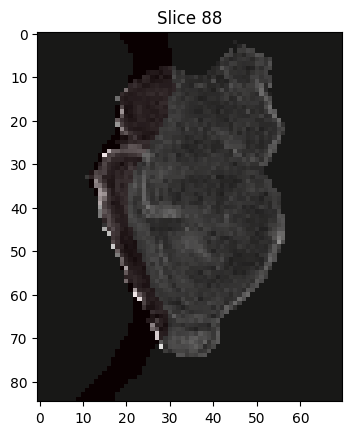

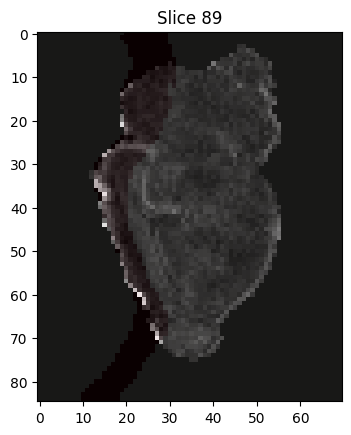

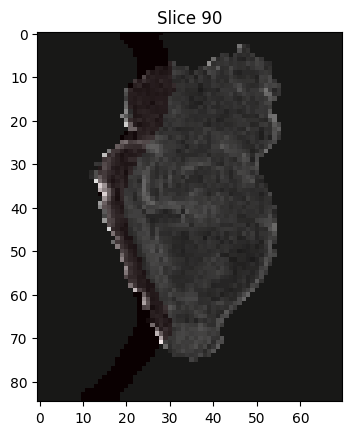

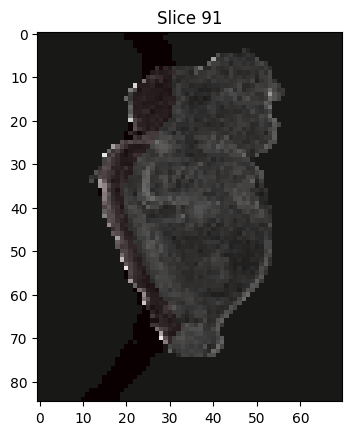

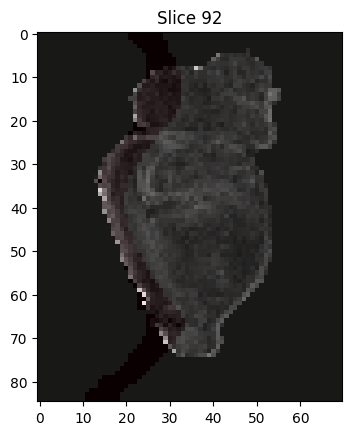

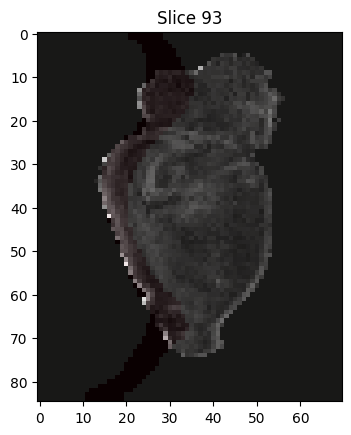

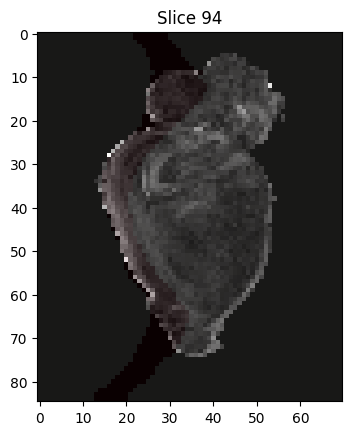

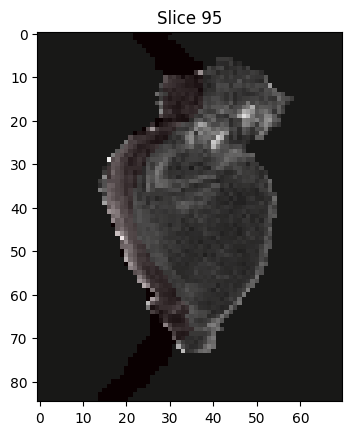

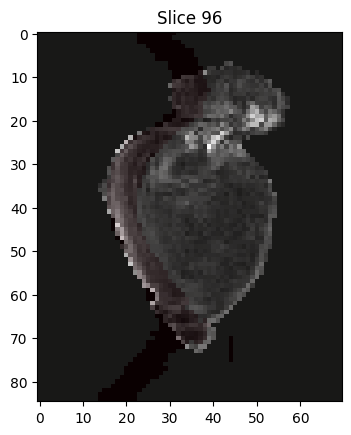

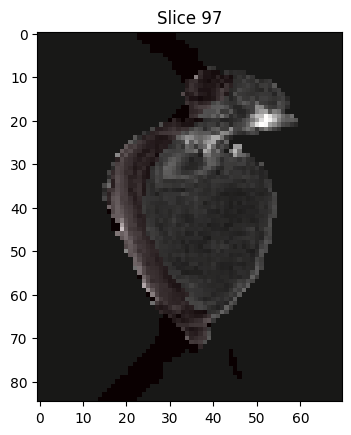

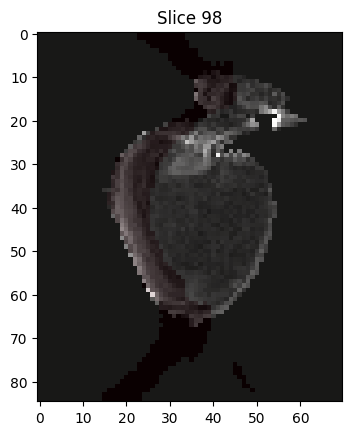

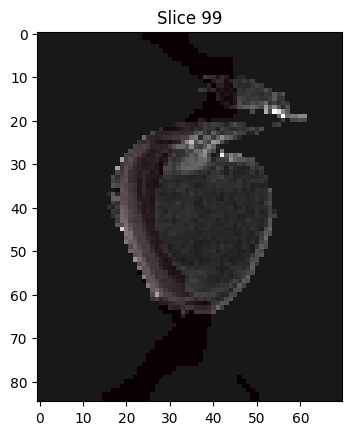

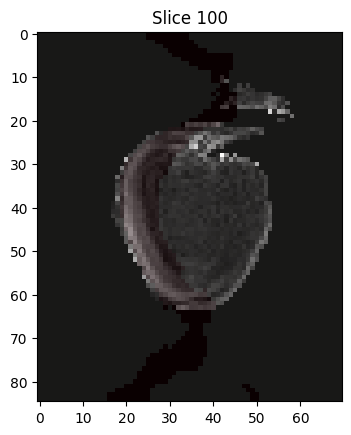

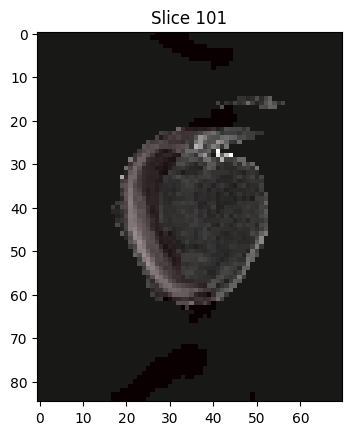

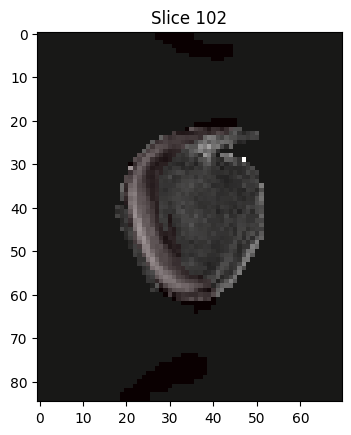

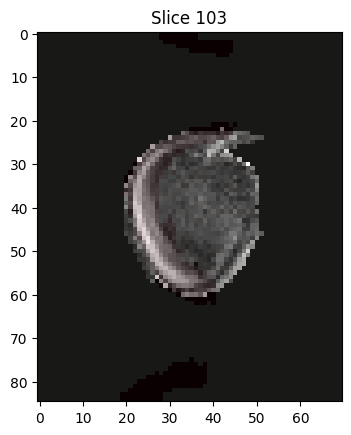

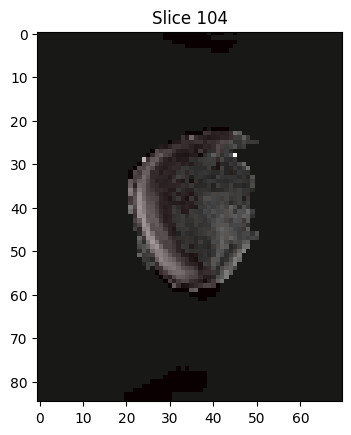

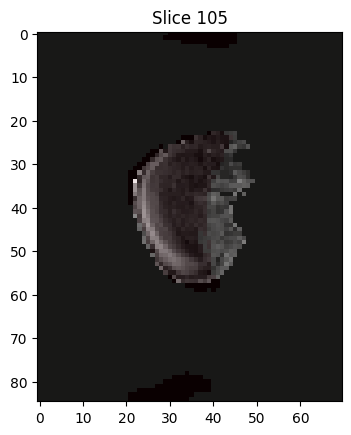

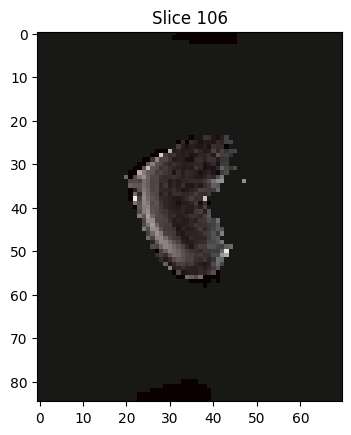

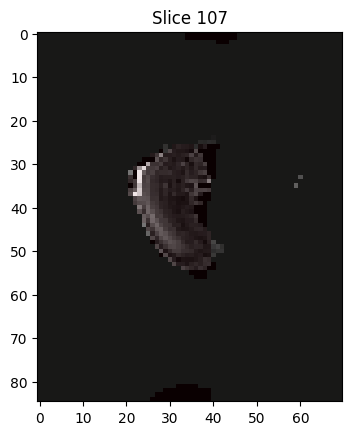

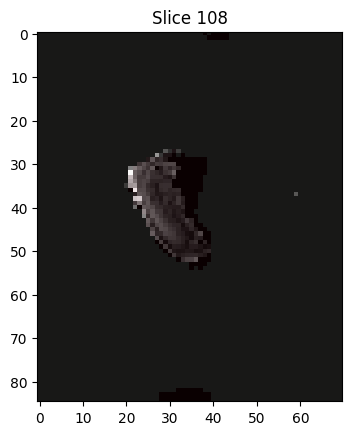

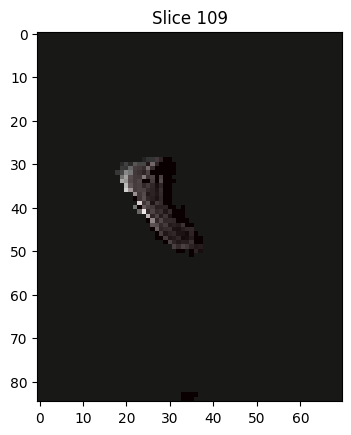

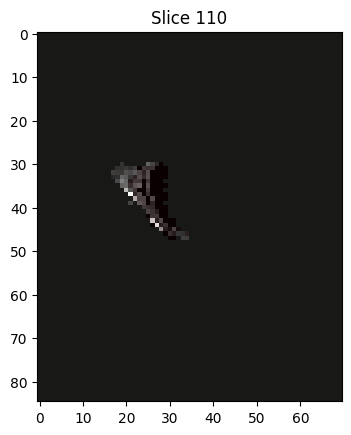

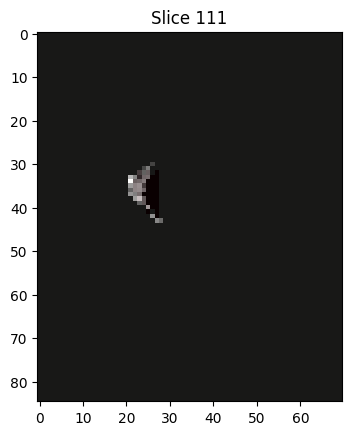

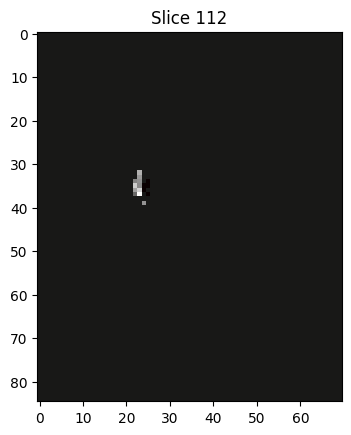

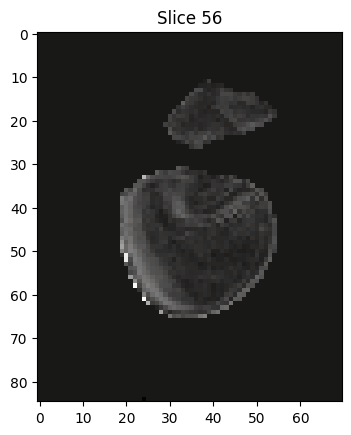

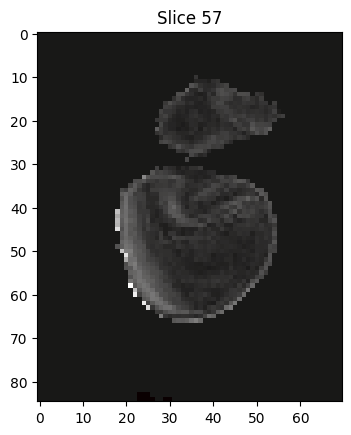

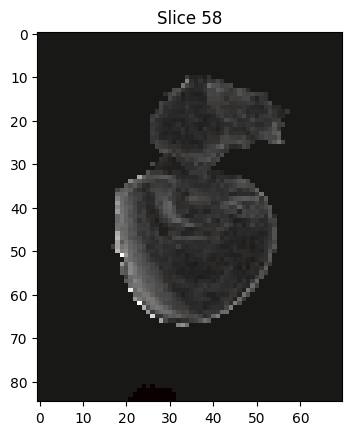

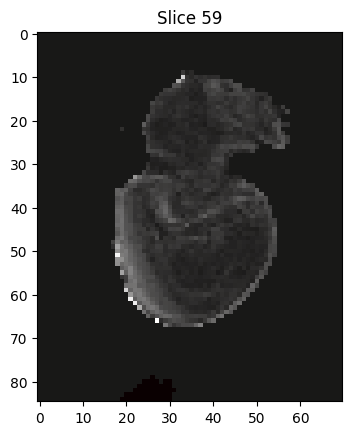

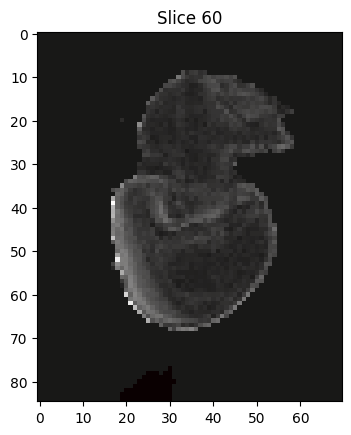

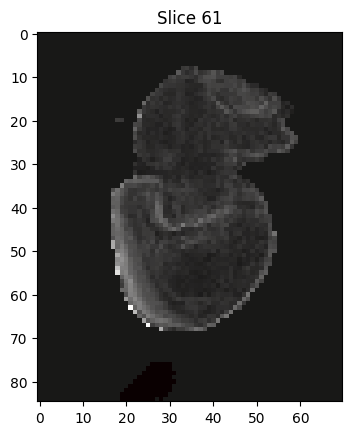

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [92]:
for structure in ['Pall', 'DPall', 'MPall']:
    mask = atlas.get_structure_mask(structure)
    plot_roi_on_image(mask, reoriented_fa_map, '../P0/PDF/PDF_result.pdf')

In [91]:
def plot_roi_on_image(mask, reoriented_fa_map, output_file):
    
    # Transform to data arrays
    img_data = reoriented_fa_map.get_fdata()
    roi_data = apply_transform_to_mask(mask, transform, reoriented_fa_map).numpy()
    # Get the non-zero slices from the roi
    non_zero_slices = np.nonzero(np.any(roi_data, axis=(1, 0)))[0]

    for i in non_zero_slices:
            fig, ax = plt.subplots()
            plt.imshow(img_data[:,:,i], cmap="gray")
            plt.imshow(roi_data[:,:,i], alpha=0.1, cmap="Reds")  
            plt.title(f"Slice {i}")
            #pdf.savefig(fig) 
            #plt.close()
            plt.show()

In [126]:
non_zero_slices = np.nonzero(np.any(roi_data, axis=(0, 1)))[0]

In [93]:
roi_data = apply_transform_to_mask(mask, transform, reoriented_fa_map).numpy()

In [96]:
non_zero_slices = np.nonzero(np.any(roi_data, axis=(1, 0)))[0]

Text(0.5, 1.0, 'Slice 85')

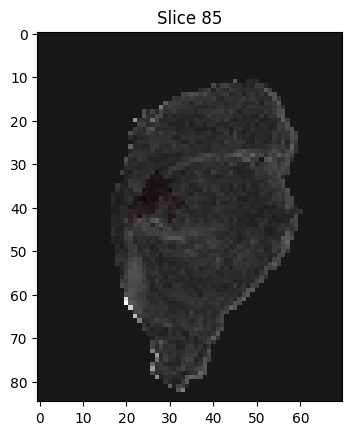

In [117]:
fig, ax = plt.subplots()
plt.imshow(reoriented_fa_map.get_fdata()[:,:,78], cmap="gray")
plt.imshow(roi_data[:,:,78], alpha=0.1, cmap="Reds")  
plt.title(f"Slice {i}")

In [128]:
structure

'MPall'

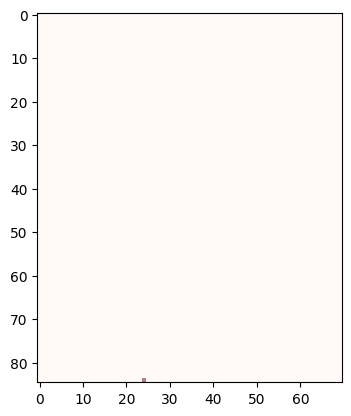

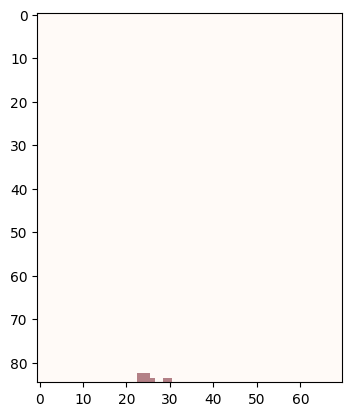

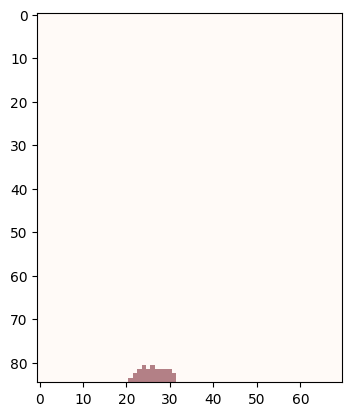

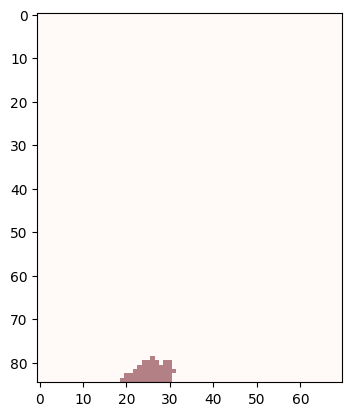

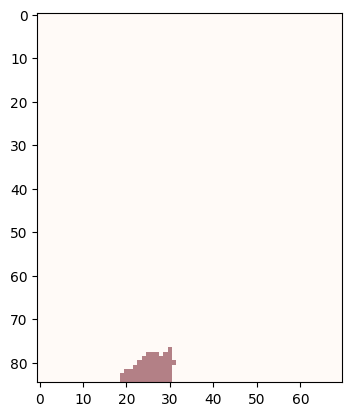

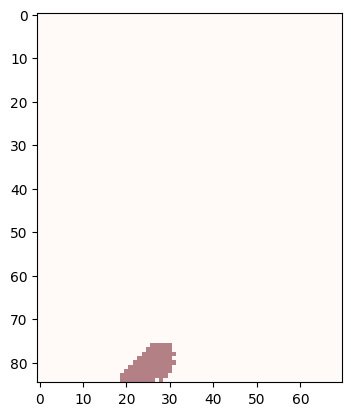

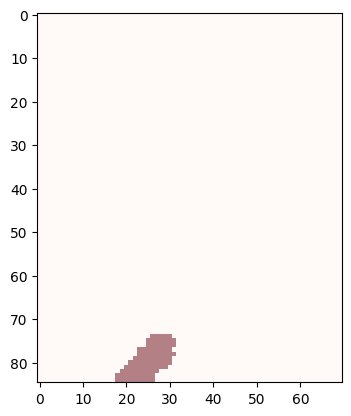

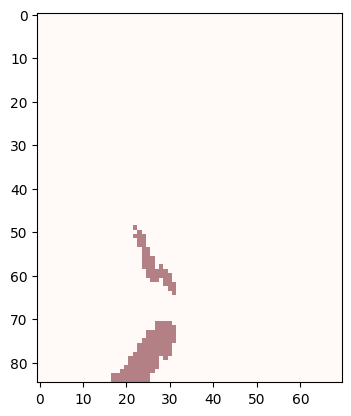

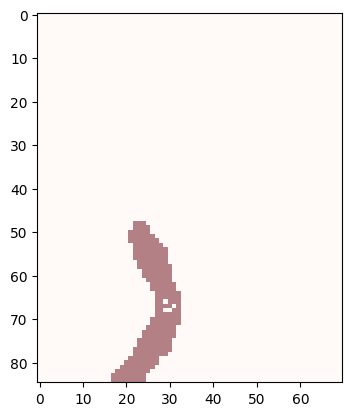

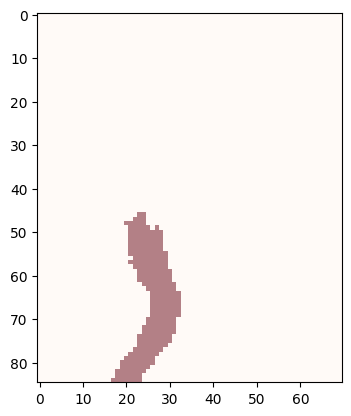

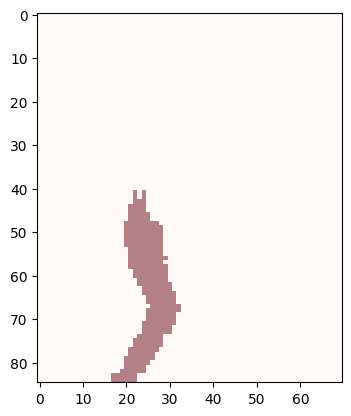

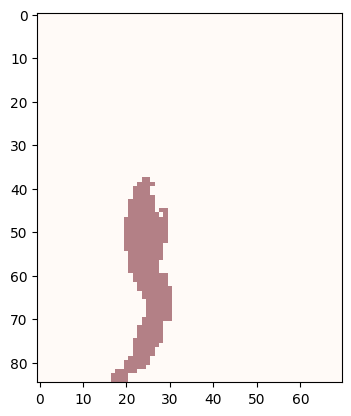

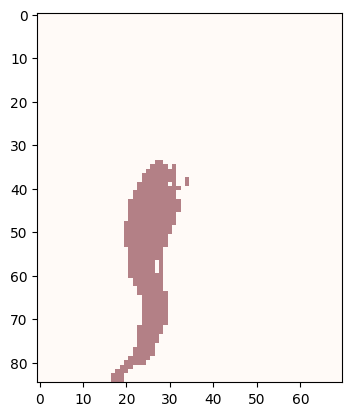

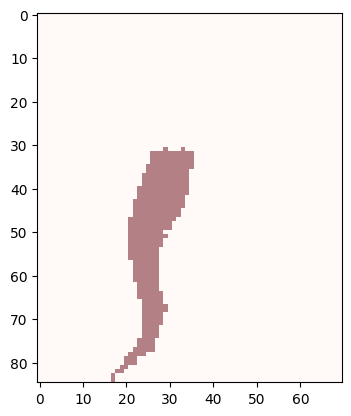

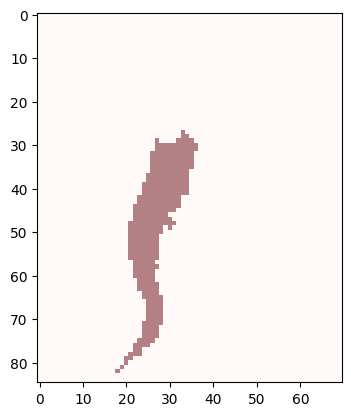

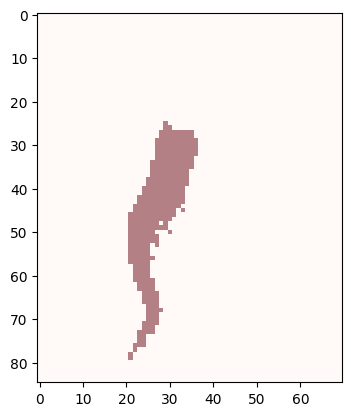

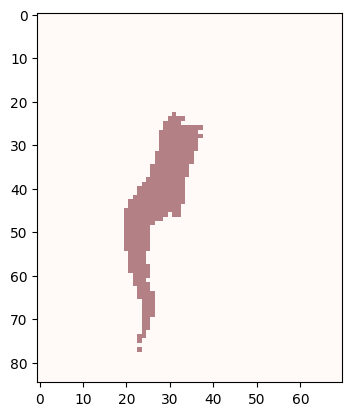

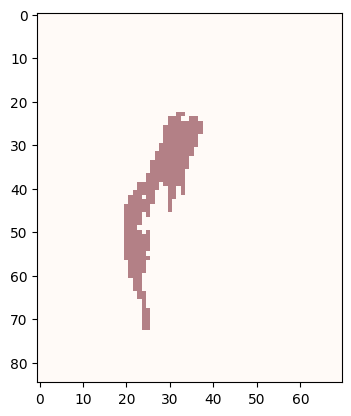

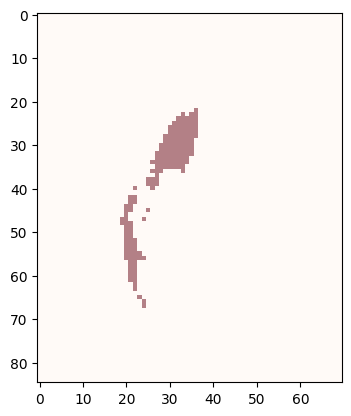

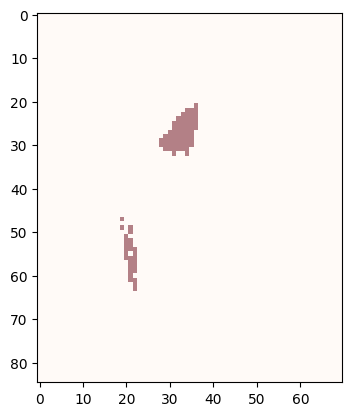

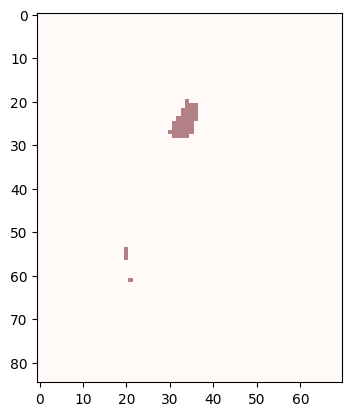

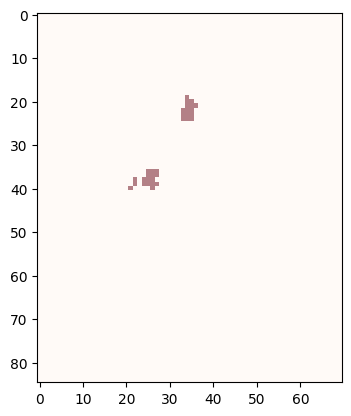

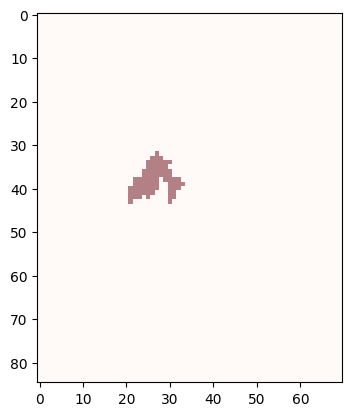

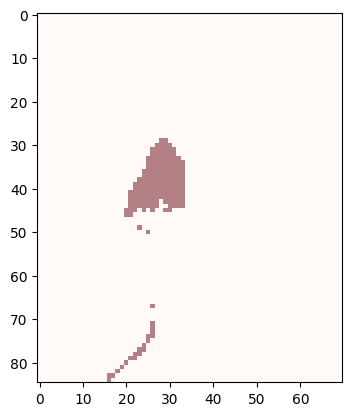

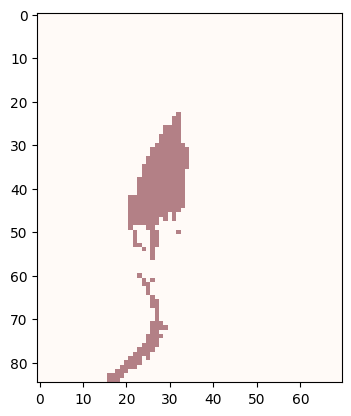

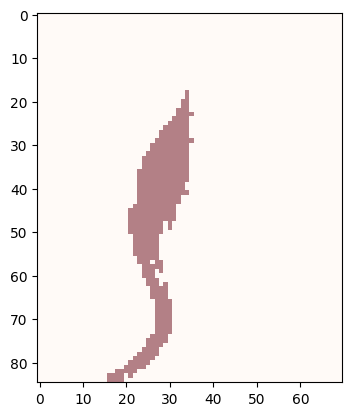

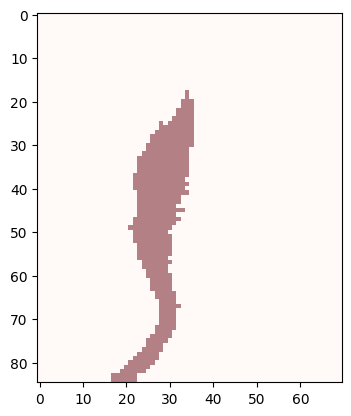

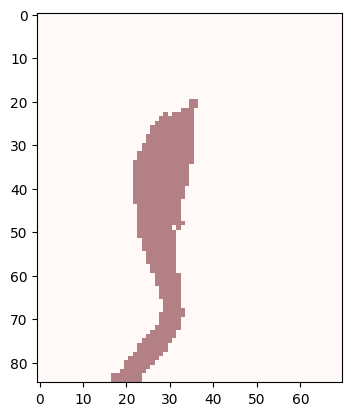

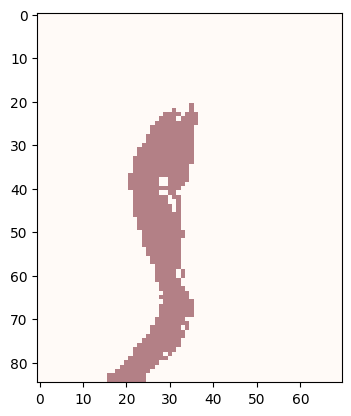

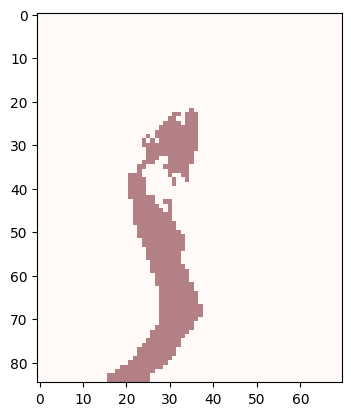

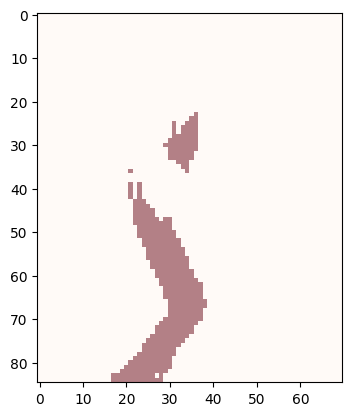

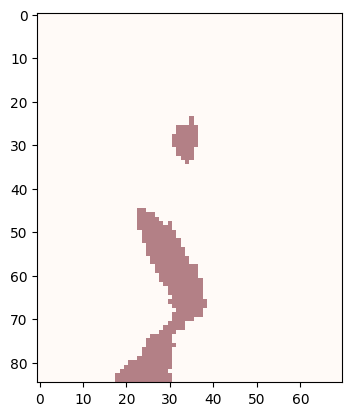

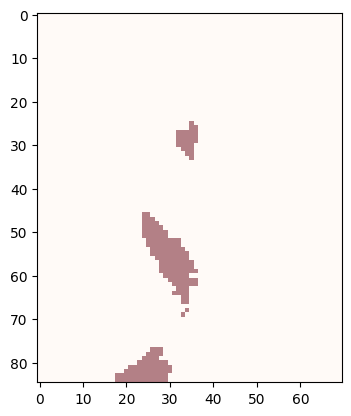

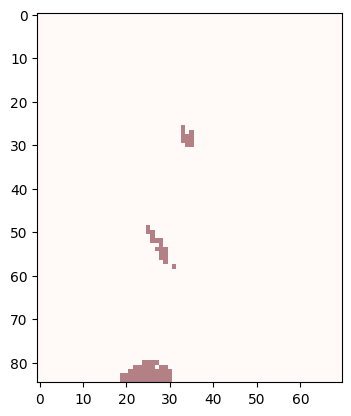

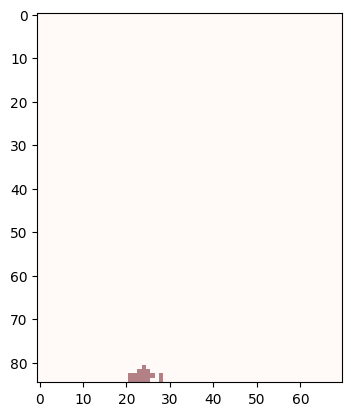

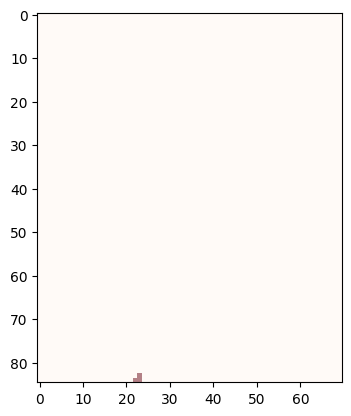

In [127]:
for i in non_zero_slices:
    plt.imshow(roi_data[:,:,i], alpha=0.5, cmap="Reds")  
    plt.show()